In [90]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

[15:51:15 - matplotlib.pyplot] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [213]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [214]:
date = "20190809"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["date"] == date].iloc[0, :])

In [215]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [39]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [77]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [58]:
from pore_utils import raw_signal_utils
from pore_utils import smith_waterman as s_w

In [78]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [216]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [200]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

[19:58:39 - __main__] Getting molbit sequences.
[19:58:39 - __main__] Locating fastq files.
[19:58:39 - __main__] Running SW, one fastq at a time.
[19:58:39 - __main__] Starting fastq (0 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_0_0.fastq


[########################################] | 100% Completed | 38.2s
[########################################] | 100% Completed | 38.2s
[########################################] | 100% Completed | 38.2s
[########################################] | 100% Completed | 38.3s
[########################################] | 100% Completed | 38.4s
[########################################] | 100% Completed | 38.5s
[########################################] | 100% Completed | 38.5s
[########################################] | 100% Completed | 38.5s
[########################################] | 100% Completed | 38.6s
[########################################] | 100% Completed | 38.6s
[########################################] | 100% Completed | 38.6s
[########################################] | 100% Completed | 38.7s
[########################################] | 100% Completed | 38.8s
[########################################] | 100% Completed | 38.9s


[19:59:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_0_0.tsv
[19:59:19 - __main__] Starting fastq (1 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_0_1.fastq


[########################################] | 100% Completed | 24.3s
[########################################] | 100% Completed | 24.3s
[########################################] | 100% Completed | 24.4s
[########################################] | 100% Completed | 24.5s
[########################################] | 100% Completed | 24.5s
[########################################] | 100% Completed | 24.6s
[########################################] | 100% Completed | 24.7s
[########################################] | 100% Completed | 24.8s
[########################################] | 100% Completed | 24.8s
[########################################] | 100% Completed | 24.9s
[########################################] | 100% Completed | 25.0s
[########################################] | 100% Completed | 25.0s
[########################################] | 100% Completed | 25.1s
[########################################] | 100% Completed | 25.2s


[19:59:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_0_1.tsv
[19:59:45 - __main__] Starting fastq (2 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_0_2.fastq


[########################################] | 100% Completed | 49.0s
[########################################] | 100% Completed | 49.0s
[########################################] | 100% Completed | 49.1s
[########################################] | 100% Completed | 49.2s
[########################################] | 100% Completed | 49.3s
[########################################] | 100% Completed | 49.3s
[########################################] | 100% Completed | 49.4s
[########################################] | 100% Completed | 49.4s
[########################################] | 100% Completed | 49.5s
[########################################] | 100% Completed | 49.6s
[########################################] | 100% Completed | 49.6s
[########################################] | 100% Completed | 49.7s
[########################################] | 100% Completed | 49.7s
[########################################] | 100% Completed | 49.8s


[20:00:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_0_2.tsv
[20:00:36 - __main__] Starting fastq (3 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_0_3.fastq


[########################################] | 100% Completed | 25.9s
[########################################] | 100% Completed | 25.9s
[########################################] | 100% Completed | 25.9s
[########################################] | 100% Completed | 26.0s
[########################################] | 100% Completed | 26.1s
[########################################] | 100% Completed | 26.1s
[########################################] | 100% Completed | 26.1s
[########################################] | 100% Completed | 26.2s
[########################################] | 100% Completed | 26.3s
[########################################] | 100% Completed | 26.3s
[########################################] | 100% Completed | 26.4s
[########################################] | 100% Completed | 26.4s
[########################################] | 100% Completed | 26.4s
[########################################] | 100% Completed | 26.5s


[20:01:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_0_3.tsv
[20:01:04 - __main__] Starting fastq (4 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_1_0.fastq


[########################################] | 100% Completed | 56.8s
[########################################] | 100% Completed | 56.9s
[########################################] | 100% Completed | 57.0s
[########################################] | 100% Completed | 57.0s
[########################################] | 100% Completed | 57.1s
[########################################] | 100% Completed | 57.2s
[########################################] | 100% Completed | 57.3s
[########################################] | 100% Completed | 57.4s
[########################################] | 100% Completed | 57.5s
[########################################] | 100% Completed | 57.5s
[########################################] | 100% Completed | 57.6s
[########################################] | 100% Completed | 57.6s
[########################################] | 100% Completed | 57.7s
[########################################] | 100% Completed | 57.7s


[20:02:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_1_0.tsv
[20:02:02 - __main__] Starting fastq (5 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_1_1.fastq


[########################################] | 100% Completed | 44.9s
[########################################] | 100% Completed | 45.0s
[########################################] | 100% Completed | 45.0s
[########################################] | 100% Completed | 45.1s
[########################################] | 100% Completed | 45.1s
[########################################] | 100% Completed | 45.2s
[########################################] | 100% Completed | 45.3s
[########################################] | 100% Completed | 45.3s
[########################################] | 100% Completed | 45.4s
[########################################] | 100% Completed | 45.5s
[########################################] | 100% Completed | 45.5s
[########################################] | 100% Completed | 45.6s
[########################################] | 100% Completed | 45.6s
[########################################] | 100% Completed | 45.7s


[20:02:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_1_1.tsv
[20:02:49 - __main__] Starting fastq (6 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_1_2.fastq


[########################################] | 100% Completed | 27.1s
[########################################] | 100% Completed | 27.2s
[########################################] | 100% Completed | 27.2s
[########################################] | 100% Completed | 27.3s
[########################################] | 100% Completed | 27.3s
[########################################] | 100% Completed | 27.3s
[########################################] | 100% Completed | 27.4s
[########################################] | 100% Completed | 27.5s
[########################################] | 100% Completed | 27.6s
[########################################] | 100% Completed | 27.6s
[########################################] | 100% Completed | 27.7s
[########################################] | 100% Completed | 27.7s
[########################################] | 100% Completed | 27.8s
[########################################] | 100% Completed | 27.9s


[20:03:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_1_2.tsv
[20:03:18 - __main__] Starting fastq (7 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_1_3.fastq


[########################################] | 100% Completed |  7.3s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  7.9s
[########################################] | 100% Completed |  7.9s


[20:03:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_1_3.tsv
[20:03:27 - __main__] Starting fastq (8 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_2_0.fastq


[########################################] | 100% Completed | 50.4s
[########################################] | 100% Completed | 50.5s
[########################################] | 100% Completed | 50.6s
[########################################] | 100% Completed | 50.6s
[########################################] | 100% Completed | 50.7s
[########################################] | 100% Completed | 50.7s
[########################################] | 100% Completed | 50.8s
[########################################] | 100% Completed | 50.9s
[########################################] | 100% Completed | 51.0s
[########################################] | 100% Completed | 51.1s
[########################################] | 100% Completed | 51.1s
[########################################] | 100% Completed | 51.1s
[########################################] | 100% Completed | 51.1s
[########################################] | 100% Completed | 51.2s


[20:04:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_2_0.tsv
[20:04:19 - __main__] Starting fastq (9 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_2_1.fastq


[########################################] | 100% Completed | 26.5s
[########################################] | 100% Completed | 26.6s
[########################################] | 100% Completed | 26.7s
[########################################] | 100% Completed | 26.7s
[########################################] | 100% Completed | 26.8s
[########################################] | 100% Completed | 26.8s
[########################################] | 100% Completed | 26.9s
[########################################] | 100% Completed | 27.0s
[########################################] | 100% Completed | 27.0s
[########################################] | 100% Completed | 27.0s
[########################################] | 100% Completed | 27.1s
[########################################] | 100% Completed | 27.1s
[########################################] | 100% Completed | 27.2s
[########################################] | 100% Completed | 27.2s


[20:04:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_2_1.tsv
[20:04:47 - __main__] Starting fastq (10 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_2_2.fastq


[########################################] | 100% Completed | 49.5s
[########################################] | 100% Completed | 49.6s
[########################################] | 100% Completed | 49.7s
[########################################] | 100% Completed | 49.7s
[########################################] | 100% Completed | 49.8s
[########################################] | 100% Completed | 49.9s
[########################################] | 100% Completed | 50.0s
[########################################] | 100% Completed | 50.0s
[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 50.2s
[########################################] | 100% Completed | 50.2s
[########################################] | 100% Completed | 50.3s
[########################################] | 100% Completed | 50.3s
[########################################] | 100% Completed | 50.4s


[20:05:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_2_2.tsv
[20:05:39 - __main__] Starting fastq (11 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_2_3.fastq


[########################################] | 100% Completed | 12.7s
[########################################] | 100% Completed | 12.7s
[########################################] | 100% Completed | 12.7s
[########################################] | 100% Completed | 12.7s
[########################################] | 100% Completed | 12.8s
[########################################] | 100% Completed | 12.9s
[########################################] | 100% Completed | 12.9s
[########################################] | 100% Completed | 13.0s
[########################################] | 100% Completed | 13.1s
[########################################] | 100% Completed | 13.2s
[########################################] | 100% Completed | 13.3s
[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed | 13.5s


[20:05:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_2_3.tsv
[20:05:53 - __main__] Starting fastq (12 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_3_0.fastq


[########################################] | 100% Completed | 44.2s
[########################################] | 100% Completed | 44.3s
[########################################] | 100% Completed | 44.3s
[########################################] | 100% Completed | 44.4s
[########################################] | 100% Completed | 44.4s
[########################################] | 100% Completed | 44.5s
[########################################] | 100% Completed | 44.5s
[########################################] | 100% Completed | 44.6s
[########################################] | 100% Completed | 44.7s
[########################################] | 100% Completed | 44.7s
[########################################] | 100% Completed | 44.7s
[########################################] | 100% Completed | 44.8s
[########################################] | 100% Completed | 44.9s
[########################################] | 100% Completed | 44.9s


[20:06:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_3_0.tsv
[20:06:39 - __main__] Starting fastq (13 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_3_1.fastq


[########################################] | 100% Completed | 38.2s
[########################################] | 100% Completed | 38.2s
[########################################] | 100% Completed | 38.3s
[########################################] | 100% Completed | 38.3s
[########################################] | 100% Completed | 38.4s
[########################################] | 100% Completed | 38.4s
[########################################] | 100% Completed | 38.5s
[########################################] | 100% Completed | 38.5s
[########################################] | 100% Completed | 38.6s
[########################################] | 100% Completed | 38.6s
[########################################] | 100% Completed | 38.7s
[########################################] | 100% Completed | 38.8s
[########################################] | 100% Completed | 38.9s
[########################################] | 100% Completed | 39.0s


[20:07:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_3_1.tsv
[20:07:19 - __main__] Starting fastq (14 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_3_2.fastq


[########################################] | 100% Completed | 57.0s
[########################################] | 100% Completed | 57.1s
[########################################] | 100% Completed | 57.2s
[########################################] | 100% Completed | 57.3s
[########################################] | 100% Completed | 57.3s
[########################################] | 100% Completed | 57.4s
[########################################] | 100% Completed | 57.4s
[########################################] | 100% Completed | 57.5s
[########################################] | 100% Completed | 57.6s
[########################################] | 100% Completed | 57.6s
[########################################] | 100% Completed | 57.7s
[########################################] | 100% Completed | 57.8s
[########################################] | 100% Completed | 57.8s
[########################################] | 100% Completed | 57.9s


[20:08:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_3_2.tsv
[20:08:18 - __main__] Starting fastq (15 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_4_0.fastq


[########################################] | 100% Completed | 18.6s
[########################################] | 100% Completed | 18.7s
[########################################] | 100% Completed | 18.8s
[########################################] | 100% Completed | 18.9s
[########################################] | 100% Completed | 19.0s
[########################################] | 100% Completed | 19.1s
[########################################] | 100% Completed | 19.1s
[########################################] | 100% Completed | 19.2s
[########################################] | 100% Completed | 19.2s
[########################################] | 100% Completed | 19.3s
[########################################] | 100% Completed | 19.3s
[########################################] | 100% Completed | 19.4s
[########################################] | 100% Completed | 19.5s
[########################################] | 100% Completed | 19.5s


[20:08:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_4_0.tsv
[20:08:39 - __main__] Starting fastq (16 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_3_3.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s


[20:08:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_3_3.tsv
[20:08:41 - __main__] Starting fastq (17 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_4_1.fastq


[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.8s


[20:08:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_4_1.tsv
[20:08:48 - __main__] Starting fastq (18 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_4_2.fastq


[########################################] | 100% Completed | 35.5s
[########################################] | 100% Completed | 35.5s
[########################################] | 100% Completed | 35.6s
[########################################] | 100% Completed | 35.6s
[########################################] | 100% Completed | 35.6s
[########################################] | 100% Completed | 35.7s
[########################################] | 100% Completed | 35.7s
[########################################] | 100% Completed | 35.8s
[########################################] | 100% Completed | 35.9s
[########################################] | 100% Completed | 35.9s
[########################################] | 100% Completed | 36.0s
[########################################] | 100% Completed | 36.1s
[########################################] | 100% Completed | 36.1s
[########################################] | 100% Completed | 36.2s


[20:09:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_4_2.tsv
[20:09:25 - __main__] Starting fastq (19 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_5_0.fastq


[########################################] | 100% Completed | 48.9s
[########################################] | 100% Completed | 49.0s
[########################################] | 100% Completed | 49.0s
[########################################] | 100% Completed | 49.1s
[########################################] | 100% Completed | 49.2s
[########################################] | 100% Completed | 49.3s
[########################################] | 100% Completed | 49.3s
[########################################] | 100% Completed | 49.4s
[########################################] | 100% Completed | 49.5s
[########################################] | 100% Completed | 49.5s
[########################################] | 100% Completed | 49.5s
[########################################] | 100% Completed | 49.6s
[########################################] | 100% Completed | 49.6s
[########################################] | 100% Completed | 49.6s


[20:10:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_5_0.tsv
[20:10:16 - __main__] Starting fastq (20 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_4_3.fastq


[########################################] | 100% Completed |  1min 17.5s
[########################################] | 100% Completed |  1min 17.6s
[########################################] | 100% Completed |  1min 17.7s
[########################################] | 100% Completed |  1min 17.8s
[########################################] | 100% Completed |  1min 17.9s
[########################################] | 100% Completed |  1min 17.9s
[########################################] | 100% Completed |  1min 18.0s
[########################################] | 100% Completed |  1min 18.0s
[########################################] | 100% Completed |  1min 18.1s
[########################################] | 100% Completed |  1min 18.2s
[########################################] | 100% Completed |  1min 18.3s
[########################################] | 100% Completed |  1min 18.3s
[########################################] | 100% Completed |  1min 18.3s
[#####################################

[20:11:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_4_3.tsv
[20:11:35 - __main__] Starting fastq (21 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_5_1.fastq


[########################################] | 100% Completed | 48.7s
[########################################] | 100% Completed | 48.8s
[########################################] | 100% Completed | 48.9s
[########################################] | 100% Completed | 48.9s
[########################################] | 100% Completed | 49.0s
[########################################] | 100% Completed | 49.1s
[########################################] | 100% Completed | 49.1s
[########################################] | 100% Completed | 49.1s
[########################################] | 100% Completed | 49.2s
[########################################] | 100% Completed | 49.3s
[########################################] | 100% Completed | 49.3s
[########################################] | 100% Completed | 49.4s
[########################################] | 100% Completed | 49.4s
[########################################] | 100% Completed | 49.5s


[20:12:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_5_1.tsv
[20:12:26 - __main__] Starting fastq (22 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_5_2.fastq


[########################################] | 100% Completed | 30.0s
[########################################] | 100% Completed | 30.1s
[########################################] | 100% Completed | 30.1s
[########################################] | 100% Completed | 30.2s
[########################################] | 100% Completed | 30.2s
[########################################] | 100% Completed | 30.3s
[########################################] | 100% Completed | 30.4s
[########################################] | 100% Completed | 30.5s
[########################################] | 100% Completed | 30.6s
[########################################] | 100% Completed | 30.7s
[########################################] | 100% Completed | 30.8s
[########################################] | 100% Completed | 30.8s
[########################################] | 100% Completed | 30.9s
[########################################] | 100% Completed | 31.0s


[20:12:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_5_2.tsv
[20:12:58 - __main__] Starting fastq (23 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_6_0.fastq


[########################################] | 100% Completed |  1min 21.5s
[########################################] | 100% Completed |  1min 21.6s
[########################################] | 100% Completed |  1min 21.7s
[########################################] | 100% Completed |  1min 21.8s
[########################################] | 100% Completed |  1min 21.8s
[########################################] | 100% Completed |  1min 21.9s
[########################################] | 100% Completed |  1min 22.0s
[########################################] | 100% Completed |  1min 22.0s
[########################################] | 100% Completed |  1min 22.1s
[########################################] | 100% Completed |  1min 22.2s
[########################################] | 100% Completed |  1min 22.2s
[########################################] | 100% Completed |  1min 22.3s
[########################################] | 100% Completed |  1min 22.3s
[#####################################

[20:14:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_6_0.tsv
[20:14:21 - __main__] Starting fastq (24 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_6_1.fastq


[########################################] | 100% Completed | 13.8s
[########################################] | 100% Completed | 13.9s
[########################################] | 100% Completed | 13.9s
[########################################] | 100% Completed | 14.0s
[########################################] | 100% Completed | 14.0s
[########################################] | 100% Completed | 14.1s
[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 14.3s
[########################################] | 100% Completed | 14.3s
[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.5s


[20:14:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_6_1.tsv
[20:14:37 - __main__] Starting fastq (25 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_6_2.fastq


[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.3s


[20:14:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_6_2.tsv
[20:14:43 - __main__] Starting fastq (26 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_5_3.fastq


[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  7.9s
[########################################] | 100% Completed |  8.0s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.2s


[20:14:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_5_3.tsv
[20:14:52 - __main__] Starting fastq (27 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_7_0.fastq


[########################################] | 100% Completed | 50.0s
[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 50.2s
[########################################] | 100% Completed | 50.2s
[########################################] | 100% Completed | 50.3s
[########################################] | 100% Completed | 50.3s
[########################################] | 100% Completed | 50.4s
[########################################] | 100% Completed | 50.4s
[########################################] | 100% Completed | 50.5s
[########################################] | 100% Completed | 50.5s
[########################################] | 100% Completed | 50.6s
[########################################] | 100% Completed | 50.7s
[########################################] | 100% Completed | 50.7s
[########################################] | 100% Completed | 50.7s


[20:15:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_7_0.tsv
[20:15:44 - __main__] Starting fastq (28 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_6_3.fastq


[########################################] | 100% Completed | 34.7s
[########################################] | 100% Completed | 34.8s
[########################################] | 100% Completed | 34.9s
[########################################] | 100% Completed | 34.9s
[########################################] | 100% Completed | 34.9s
[########################################] | 100% Completed | 35.0s
[########################################] | 100% Completed | 35.0s
[########################################] | 100% Completed | 35.1s
[########################################] | 100% Completed | 35.2s
[########################################] | 100% Completed | 35.2s
[########################################] | 100% Completed | 35.2s
[########################################] | 100% Completed | 35.3s
[########################################] | 100% Completed | 35.4s
[########################################] | 100% Completed | 35.4s


[20:16:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_6_3.tsv
[20:16:21 - __main__] Starting fastq (29 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_7_1.fastq


[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.5s


[20:16:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_7_1.tsv
[20:16:25 - __main__] Starting fastq (30 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_7_2.fastq


[########################################] | 100% Completed | 16.4s
[########################################] | 100% Completed | 16.4s
[########################################] | 100% Completed | 16.5s
[########################################] | 100% Completed | 16.6s
[########################################] | 100% Completed | 16.7s
[########################################] | 100% Completed | 16.8s
[########################################] | 100% Completed | 16.9s
[########################################] | 100% Completed | 16.9s
[########################################] | 100% Completed | 16.9s
[########################################] | 100% Completed | 17.0s
[########################################] | 100% Completed | 17.0s
[########################################] | 100% Completed | 17.1s
[########################################] | 100% Completed | 17.1s
[########################################] | 100% Completed | 17.2s


[20:16:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_7_2.tsv
[20:16:43 - __main__] Starting fastq (31 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_7_3.fastq


[########################################] | 100% Completed |  1min  6.5s
[########################################] | 100% Completed |  1min  6.6s
[########################################] | 100% Completed |  1min  6.7s
[########################################] | 100% Completed |  1min  6.8s
[########################################] | 100% Completed |  1min  6.8s
[########################################] | 100% Completed |  1min  6.9s
[########################################] | 100% Completed |  1min  7.0s
[########################################] | 100% Completed |  1min  7.0s
[########################################] | 100% Completed |  1min  7.1s
[########################################] | 100% Completed |  1min  7.2s
[########################################] | 100% Completed |  1min  7.3s
[########################################] | 100% Completed |  1min  7.3s
[########################################] | 100% Completed |  1min  7.4s
[#####################################

[20:17:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_7_3.tsv
[20:17:52 - __main__] Starting fastq (32 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_8_0.fastq


[########################################] | 100% Completed |  1min  5.1s
[########################################] | 100% Completed |  1min  5.2s
[########################################] | 100% Completed |  1min  5.3s
[########################################] | 100% Completed |  1min  5.3s
[########################################] | 100% Completed |  1min  5.4s
[########################################] | 100% Completed |  1min  5.5s
[########################################] | 100% Completed |  1min  5.6s
[########################################] | 100% Completed |  1min  5.6s
[########################################] | 100% Completed |  1min  5.6s
[########################################] | 100% Completed |  1min  5.7s
[########################################] | 100% Completed |  1min  5.8s
[########################################] | 100% Completed |  1min  5.8s
[########################################] | 100% Completed |  1min  5.8s
[#####################################

[20:18:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_8_0.tsv
[20:18:59 - __main__] Starting fastq (33 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_8_1.fastq


[########################################] | 100% Completed | 40.0s
[########################################] | 100% Completed | 40.0s
[########################################] | 100% Completed | 40.0s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.2s
[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed | 40.4s
[########################################] | 100% Completed | 40.4s
[########################################] | 100% Completed | 40.5s
[########################################] | 100% Completed | 40.5s
[########################################] | 100% Completed | 40.6s
[########################################] | 100% Completed | 40.6s
[########################################] | 100% Completed | 40.7s


[20:19:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_8_1.tsv
[20:19:41 - __main__] Starting fastq (34 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_9_0.fastq


[########################################] | 100% Completed |  1min  5.5s
[########################################] | 100% Completed |  1min  5.5s
[########################################] | 100% Completed |  1min  5.6s
[########################################] | 100% Completed |  1min  5.7s
[########################################] | 100% Completed |  1min  5.7s
[########################################] | 100% Completed |  1min  5.8s
[########################################] | 100% Completed |  1min  5.9s
[########################################] | 100% Completed |  1min  6.0s
[########################################] | 100% Completed |  1min  6.0s
[########################################] | 100% Completed |  1min  6.1s
[########################################] | 100% Completed |  1min  6.1s
[########################################] | 100% Completed |  1min  6.2s
[########################################] | 100% Completed |  1min  6.3s
[#####################################

[20:20:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_9_0.tsv
[20:20:48 - __main__] Starting fastq (35 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_8_2.fastq


[########################################] | 100% Completed | 30.4s
[########################################] | 100% Completed | 30.4s
[########################################] | 100% Completed | 30.5s
[########################################] | 100% Completed | 30.5s
[########################################] | 100% Completed | 30.5s
[########################################] | 100% Completed | 30.6s
[########################################] | 100% Completed | 30.6s
[########################################] | 100% Completed | 30.7s
[########################################] | 100% Completed | 30.7s
[########################################] | 100% Completed | 30.8s
[########################################] | 100% Completed | 30.9s
[########################################] | 100% Completed | 30.9s
[########################################] | 100% Completed | 30.9s
[########################################] | 100% Completed | 31.0s


[20:21:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_8_2.tsv
[20:21:20 - __main__] Starting fastq (36 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_9_1.fastq


[########################################] | 100% Completed | 40.6s
[########################################] | 100% Completed | 40.7s
[########################################] | 100% Completed | 40.8s
[########################################] | 100% Completed | 40.8s
[########################################] | 100% Completed | 40.9s
[########################################] | 100% Completed | 41.0s
[########################################] | 100% Completed | 41.0s
[########################################] | 100% Completed | 41.1s
[########################################] | 100% Completed | 41.2s
[########################################] | 100% Completed | 41.3s
[########################################] | 100% Completed | 41.3s
[########################################] | 100% Completed | 41.3s
[########################################] | 100% Completed | 41.4s
[########################################] | 100% Completed | 41.5s


[20:22:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_9_1.tsv
[20:22:03 - __main__] Starting fastq (37 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_8_3.fastq


[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s


[20:22:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_8_3.tsv
[20:22:06 - __main__] Starting fastq (38 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_9_2.fastq


[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 14.3s
[########################################] | 100% Completed | 14.3s
[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.5s
[########################################] | 100% Completed | 14.6s
[########################################] | 100% Completed | 14.6s
[########################################] | 100% Completed | 14.7s
[########################################] | 100% Completed | 14.8s
[########################################] | 100% Completed | 14.9s
[########################################] | 100% Completed | 14.9s
[########################################] | 100% Completed | 14.9s


[20:22:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_9_2.tsv
[20:22:21 - __main__] Starting fastq (39 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_10_0.fastq


[########################################] | 100% Completed | 40.0s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.2s
[########################################] | 100% Completed | 40.2s
[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed | 40.4s
[########################################] | 100% Completed | 40.4s
[########################################] | 100% Completed | 40.5s
[########################################] | 100% Completed | 40.6s
[########################################] | 100% Completed | 40.6s
[########################################] | 100% Completed | 40.7s
[########################################] | 100% Completed | 40.7s
[########################################] | 100% Completed | 40.8s


[20:23:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_10_0.tsv
[20:23:03 - __main__] Starting fastq (40 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_10_1.fastq


[########################################] | 100% Completed | 17.3s
[########################################] | 100% Completed | 17.4s
[########################################] | 100% Completed | 17.5s
[########################################] | 100% Completed | 17.5s
[########################################] | 100% Completed | 17.5s
[########################################] | 100% Completed | 17.6s
[########################################] | 100% Completed | 17.7s
[########################################] | 100% Completed | 17.7s
[########################################] | 100% Completed | 17.8s
[########################################] | 100% Completed | 17.9s
[########################################] | 100% Completed | 17.9s
[########################################] | 100% Completed | 18.0s
[########################################] | 100% Completed | 18.0s
[########################################] | 100% Completed | 18.1s


[20:23:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_10_1.tsv
[20:23:22 - __main__] Starting fastq (41 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_9_3.fastq


[########################################] | 100% Completed | 18.4s
[########################################] | 100% Completed | 18.4s
[########################################] | 100% Completed | 18.4s
[########################################] | 100% Completed | 18.5s
[########################################] | 100% Completed | 18.5s
[########################################] | 100% Completed | 18.6s
[########################################] | 100% Completed | 18.6s
[########################################] | 100% Completed | 18.7s
[########################################] | 100% Completed | 18.8s
[########################################] | 100% Completed | 18.8s
[########################################] | 100% Completed | 18.8s
[########################################] | 100% Completed | 18.9s
[########################################] | 100% Completed | 19.0s
[########################################] | 100% Completed | 19.1s


[20:23:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_9_3.tsv
[20:23:42 - __main__] Starting fastq (42 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_10_2.fastq


[########################################] | 100% Completed | 31.2s
[########################################] | 100% Completed | 31.3s
[########################################] | 100% Completed | 31.4s
[########################################] | 100% Completed | 31.5s
[########################################] | 100% Completed | 31.5s
[########################################] | 100% Completed | 31.5s
[########################################] | 100% Completed | 31.5s
[########################################] | 100% Completed | 31.6s
[########################################] | 100% Completed | 31.7s
[########################################] | 100% Completed | 31.7s
[########################################] | 100% Completed | 31.8s
[########################################] | 100% Completed | 31.8s
[########################################] | 100% Completed | 31.9s
[########################################] | 100% Completed | 31.9s


[20:24:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_10_2.tsv
[20:24:15 - __main__] Starting fastq (43 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_11_0.fastq


[########################################] | 100% Completed | 39.3s
[########################################] | 100% Completed | 39.4s
[########################################] | 100% Completed | 39.5s
[########################################] | 100% Completed | 39.5s
[########################################] | 100% Completed | 39.5s
[########################################] | 100% Completed | 39.5s
[########################################] | 100% Completed | 39.6s
[########################################] | 100% Completed | 39.6s
[########################################] | 100% Completed | 39.7s
[########################################] | 100% Completed | 39.7s
[########################################] | 100% Completed | 39.8s
[########################################] | 100% Completed | 39.9s
[########################################] | 100% Completed | 39.9s
[########################################] | 100% Completed | 40.0s


[20:24:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_11_0.tsv
[20:24:56 - __main__] Starting fastq (44 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_11_1.fastq


[########################################] | 100% Completed | 30.2s
[########################################] | 100% Completed | 30.3s
[########################################] | 100% Completed | 30.3s
[########################################] | 100% Completed | 30.4s
[########################################] | 100% Completed | 30.5s
[########################################] | 100% Completed | 30.6s
[########################################] | 100% Completed | 30.6s
[########################################] | 100% Completed | 30.6s
[########################################] | 100% Completed | 30.7s
[########################################] | 100% Completed | 30.7s
[########################################] | 100% Completed | 30.7s
[########################################] | 100% Completed | 30.8s
[########################################] | 100% Completed | 30.8s
[########################################] | 100% Completed | 30.8s


[20:25:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_11_1.tsv
[20:25:28 - __main__] Starting fastq (45 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_10_3.fastq


[########################################] | 100% Completed | 49.2s
[########################################] | 100% Completed | 49.2s
[########################################] | 100% Completed | 49.3s
[########################################] | 100% Completed | 49.4s
[########################################] | 100% Completed | 49.4s
[########################################] | 100% Completed | 49.5s
[########################################] | 100% Completed | 49.6s
[########################################] | 100% Completed | 49.6s
[########################################] | 100% Completed | 49.7s
[########################################] | 100% Completed | 49.8s
[########################################] | 100% Completed | 49.8s
[########################################] | 100% Completed | 49.9s
[########################################] | 100% Completed | 50.0s
[########################################] | 100% Completed | 50.1s


[20:26:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_10_3.tsv
[20:26:19 - __main__] Starting fastq (46 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_11_2.fastq


[########################################] | 100% Completed |  1min  5.7s
[########################################] | 100% Completed |  1min  5.7s
[########################################] | 100% Completed |  1min  5.7s
[########################################] | 100% Completed |  1min  5.8s
[########################################] | 100% Completed |  1min  5.9s
[########################################] | 100% Completed |  1min  6.0s
[########################################] | 100% Completed |  1min  6.1s
[########################################] | 100% Completed |  1min  6.2s
[########################################] | 100% Completed |  1min  6.2s
[########################################] | 100% Completed |  1min  6.2s
[########################################] | 100% Completed |  1min  6.3s
[########################################] | 100% Completed |  1min  6.3s
[########################################] | 100% Completed |  1min  6.4s
[#####################################

[20:27:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_11_2.tsv
[20:27:27 - __main__] Starting fastq (47 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_12_0.fastq


[########################################] | 100% Completed |  1min 13.2s
[########################################] | 100% Completed |  1min 13.3s
[########################################] | 100% Completed |  1min 13.3s
[########################################] | 100% Completed |  1min 13.4s
[########################################] | 100% Completed |  1min 13.4s
[########################################] | 100% Completed |  1min 13.5s
[########################################] | 100% Completed |  1min 13.5s
[########################################] | 100% Completed |  1min 13.6s
[########################################] | 100% Completed |  1min 13.7s
[########################################] | 100% Completed |  1min 13.8s
[########################################] | 100% Completed |  1min 13.8s
[########################################] | 100% Completed |  1min 13.9s
[########################################] | 100% Completed |  1min 13.9s
[#####################################

[20:28:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_12_0.tsv
[20:28:42 - __main__] Starting fastq (48 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_11_3.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s


[20:28:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_11_3.tsv
[20:28:45 - __main__] Starting fastq (49 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_12_1.fastq


[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s


[20:28:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_12_1.tsv
[20:28:47 - __main__] Starting fastq (50 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_12_2.fastq


[########################################] | 100% Completed | 59.3s
[########################################] | 100% Completed | 59.3s
[########################################] | 100% Completed | 59.4s
[########################################] | 100% Completed | 59.4s
[########################################] | 100% Completed | 59.5s
[########################################] | 100% Completed | 59.5s
[########################################] | 100% Completed | 59.6s
[########################################] | 100% Completed | 59.6s
[########################################] | 100% Completed | 59.7s
[########################################] | 100% Completed | 59.7s
[########################################] | 100% Completed | 59.8s
[########################################] | 100% Completed | 59.9s
[########################################] | 100% Completed | 59.9s
[########################################] | 100% Completed | 59.9s


[20:29:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_12_2.tsv
[20:29:48 - __main__] Starting fastq (51 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_12_3.fastq


[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.8s


[20:29:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_12_3.tsv
[20:29:54 - __main__] Starting fastq (52 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_13_0.fastq


[########################################] | 100% Completed |  1min 17.3s
[########################################] | 100% Completed |  1min 17.3s
[########################################] | 100% Completed |  1min 17.4s
[########################################] | 100% Completed |  1min 17.5s
[########################################] | 100% Completed |  1min 17.5s
[########################################] | 100% Completed |  1min 17.6s
[########################################] | 100% Completed |  1min 17.6s
[########################################] | 100% Completed |  1min 17.7s
[########################################] | 100% Completed |  1min 17.7s
[########################################] | 100% Completed |  1min 17.7s
[########################################] | 100% Completed |  1min 17.8s
[########################################] | 100% Completed |  1min 17.9s
[########################################] | 100% Completed |  1min 17.9s
[#####################################

[20:31:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_13_0.tsv
[20:31:13 - __main__] Starting fastq (53 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_13_1.fastq


[########################################] | 100% Completed | 50.3s
[########################################] | 100% Completed | 50.4s
[########################################] | 100% Completed | 50.4s
[########################################] | 100% Completed | 50.4s
[########################################] | 100% Completed | 50.5s
[########################################] | 100% Completed | 50.6s
[########################################] | 100% Completed | 50.6s
[########################################] | 100% Completed | 50.7s
[########################################] | 100% Completed | 50.7s
[########################################] | 100% Completed | 50.8s
[########################################] | 100% Completed | 50.9s
[########################################] | 100% Completed | 50.9s
[########################################] | 100% Completed | 51.0s
[########################################] | 100% Completed | 51.0s


[20:32:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_13_1.tsv
[20:32:05 - __main__] Starting fastq (54 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_14_0.fastq


[########################################] | 100% Completed |  1min  7.7s
[########################################] | 100% Completed |  1min  7.8s
[########################################] | 100% Completed |  1min  7.8s
[########################################] | 100% Completed |  1min  7.9s
[########################################] | 100% Completed |  1min  8.0s
[########################################] | 100% Completed |  1min  8.0s
[########################################] | 100% Completed |  1min  8.1s
[########################################] | 100% Completed |  1min  8.2s
[########################################] | 100% Completed |  1min  8.2s
[########################################] | 100% Completed |  1min  8.3s
[########################################] | 100% Completed |  1min  8.4s
[########################################] | 100% Completed |  1min  8.4s
[########################################] | 100% Completed |  1min  8.4s
[#####################################

[20:33:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_14_0.tsv
[20:33:14 - __main__] Starting fastq (55 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_13_2.fastq


[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  9.6s
[########################################] | 100% Completed |  9.7s
[########################################] | 100% Completed |  9.8s
[########################################] | 100% Completed |  9.8s
[########################################] | 100% Completed |  9.8s
[########################################] | 100% Completed |  9.9s
[########################################] | 100% Completed | 10.0s
[########################################] | 100% Completed | 10.0s
[########################################] | 100% Completed | 10.1s
[########################################] | 100% Completed | 10.2s
[########################################] | 100% Completed | 10.2s
[########################################] | 100% Completed | 10.3s


[20:33:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_13_2.tsv
[20:33:26 - __main__] Starting fastq (56 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_14_1.fastq


[########################################] | 100% Completed | 33.0s
[########################################] | 100% Completed | 33.0s
[########################################] | 100% Completed | 33.0s
[########################################] | 100% Completed | 33.1s
[########################################] | 100% Completed | 33.1s
[########################################] | 100% Completed | 33.2s
[########################################] | 100% Completed | 33.2s
[########################################] | 100% Completed | 33.2s
[########################################] | 100% Completed | 33.2s
[########################################] | 100% Completed | 33.3s
[########################################] | 100% Completed | 33.4s
[########################################] | 100% Completed | 33.4s
[########################################] | 100% Completed | 33.5s
[########################################] | 100% Completed | 33.5s


[20:34:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_14_1.tsv
[20:34:00 - __main__] Starting fastq (57 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_13_3.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s


[20:34:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_13_3.tsv
[20:34:03 - __main__] Starting fastq (58 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_14_2.fastq


[########################################] | 100% Completed | 23.8s
[########################################] | 100% Completed | 23.9s
[########################################] | 100% Completed | 23.9s
[########################################] | 100% Completed | 24.0s
[########################################] | 100% Completed | 24.0s
[########################################] | 100% Completed | 24.1s
[########################################] | 100% Completed | 24.1s
[########################################] | 100% Completed | 24.2s
[########################################] | 100% Completed | 24.2s
[########################################] | 100% Completed | 24.3s
[########################################] | 100% Completed | 24.4s
[########################################] | 100% Completed | 24.5s
[########################################] | 100% Completed | 24.5s
[########################################] | 100% Completed | 24.6s


[20:34:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_14_2.tsv
[20:34:29 - __main__] Starting fastq (59 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_15_0.fastq


[########################################] | 100% Completed | 45.4s
[########################################] | 100% Completed | 45.5s
[########################################] | 100% Completed | 45.6s
[########################################] | 100% Completed | 45.6s
[########################################] | 100% Completed | 45.7s
[########################################] | 100% Completed | 45.7s
[########################################] | 100% Completed | 45.8s
[########################################] | 100% Completed | 45.8s
[########################################] | 100% Completed | 45.8s
[########################################] | 100% Completed | 45.9s
[########################################] | 100% Completed | 46.0s
[########################################] | 100% Completed | 46.0s
[########################################] | 100% Completed | 46.1s
[########################################] | 100% Completed | 46.2s


[20:35:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_15_0.tsv
[20:35:16 - __main__] Starting fastq (60 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_14_3.fastq


[########################################] | 100% Completed | 11.9s
[########################################] | 100% Completed | 11.9s
[########################################] | 100% Completed | 12.0s
[########################################] | 100% Completed | 12.0s
[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 12.3s
[########################################] | 100% Completed | 12.4s
[########################################] | 100% Completed | 12.4s
[########################################] | 100% Completed | 12.5s
[########################################] | 100% Completed | 12.6s
[########################################] | 100% Completed | 12.6s
[########################################] | 100% Completed | 12.7s


[20:35:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_14_3.tsv
[20:35:29 - __main__] Starting fastq (61 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_15_1.fastq


[########################################] | 100% Completed | 48.6s
[########################################] | 100% Completed | 48.6s
[########################################] | 100% Completed | 48.7s
[########################################] | 100% Completed | 48.7s
[########################################] | 100% Completed | 48.8s
[########################################] | 100% Completed | 48.8s
[########################################] | 100% Completed | 48.9s
[########################################] | 100% Completed | 49.0s
[########################################] | 100% Completed | 49.1s
[########################################] | 100% Completed | 49.2s
[########################################] | 100% Completed | 49.2s
[########################################] | 100% Completed | 49.2s
[########################################] | 100% Completed | 49.3s
[########################################] | 100% Completed | 49.4s


[20:36:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_15_1.tsv
[20:36:20 - __main__] Starting fastq (62 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_15_2.fastq


[########################################] | 100% Completed |  8.9s
[########################################] | 100% Completed |  9.0s
[########################################] | 100% Completed |  9.0s
[########################################] | 100% Completed |  9.1s
[########################################] | 100% Completed |  9.2s
[########################################] | 100% Completed |  9.2s
[########################################] | 100% Completed |  9.3s
[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  9.6s
[########################################] | 100% Completed |  9.7s
[########################################] | 100% Completed |  9.7s
[########################################] | 100% Completed |  9.8s
[########################################] | 100% Completed |  9.8s


[20:36:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_15_2.tsv
[20:36:31 - __main__] Starting fastq (63 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_15_3.fastq


[########################################] | 100% Completed | 34.4s
[########################################] | 100% Completed | 34.5s
[########################################] | 100% Completed | 34.6s
[########################################] | 100% Completed | 34.6s
[########################################] | 100% Completed | 34.8s
[########################################] | 100% Completed | 34.8s
[########################################] | 100% Completed | 34.9s
[########################################] | 100% Completed | 35.0s
[########################################] | 100% Completed | 35.1s
[########################################] | 100% Completed | 35.1s
[########################################] | 100% Completed | 35.1s
[########################################] | 100% Completed | 35.2s
[########################################] | 100% Completed | 35.2s
[########################################] | 100% Completed | 35.3s


[20:37:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_15_3.tsv
[20:37:07 - __main__] Starting fastq (64 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_16_0.fastq


[########################################] | 100% Completed |  1min 12.9s
[########################################] | 100% Completed |  1min 13.0s
[########################################] | 100% Completed |  1min 13.1s
[########################################] | 100% Completed |  1min 13.1s
[########################################] | 100% Completed |  1min 13.1s
[########################################] | 100% Completed |  1min 13.1s
[########################################] | 100% Completed |  1min 13.1s
[########################################] | 100% Completed |  1min 13.2s
[########################################] | 100% Completed |  1min 13.2s
[########################################] | 100% Completed |  1min 13.2s
[########################################] | 100% Completed |  1min 13.2s
[########################################] | 100% Completed |  1min 13.3s
[########################################] | 100% Completed |  1min 13.3s
[#####################################

[20:38:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_16_0.tsv
[20:38:22 - __main__] Starting fastq (65 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_16_1.fastq


[########################################] | 100% Completed | 35.6s
[########################################] | 100% Completed | 35.6s
[########################################] | 100% Completed | 35.7s
[########################################] | 100% Completed | 35.7s
[########################################] | 100% Completed | 35.8s
[########################################] | 100% Completed | 35.8s
[########################################] | 100% Completed | 35.9s
[########################################] | 100% Completed | 36.0s
[########################################] | 100% Completed | 36.0s
[########################################] | 100% Completed | 36.1s
[########################################] | 100% Completed | 36.1s
[########################################] | 100% Completed | 36.2s
[########################################] | 100% Completed | 36.2s
[########################################] | 100% Completed | 36.2s


[20:38:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_16_1.tsv
[20:38:59 - __main__] Starting fastq (66 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_16_2.fastq


[########################################] | 100% Completed | 27.7s
[########################################] | 100% Completed | 27.7s
[########################################] | 100% Completed | 27.8s
[########################################] | 100% Completed | 27.9s
[########################################] | 100% Completed | 27.9s
[########################################] | 100% Completed | 28.0s
[########################################] | 100% Completed | 28.1s
[########################################] | 100% Completed | 28.2s
[########################################] | 100% Completed | 28.3s
[########################################] | 100% Completed | 28.3s
[########################################] | 100% Completed | 28.3s
[########################################] | 100% Completed | 28.4s
[########################################] | 100% Completed | 28.4s
[########################################] | 100% Completed | 28.4s


[20:39:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_16_2.tsv
[20:39:28 - __main__] Starting fastq (67 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_17_0.fastq


[########################################] | 100% Completed | 27.7s
[########################################] | 100% Completed | 27.8s
[########################################] | 100% Completed | 27.9s
[########################################] | 100% Completed | 28.0s
[########################################] | 100% Completed | 28.1s
[########################################] | 100% Completed | 28.2s
[########################################] | 100% Completed | 28.3s
[########################################] | 100% Completed | 28.4s
[########################################] | 100% Completed | 28.4s
[########################################] | 100% Completed | 28.5s
[########################################] | 100% Completed | 28.5s
[########################################] | 100% Completed | 28.6s
[########################################] | 100% Completed | 28.6s
[########################################] | 100% Completed | 28.7s


[20:39:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_17_0.tsv
[20:39:58 - __main__] Starting fastq (68 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_16_3.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s


[20:40:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_16_3.tsv
[20:40:01 - __main__] Starting fastq (69 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_17_1.fastq


[########################################] | 100% Completed | 14.9s
[########################################] | 100% Completed | 15.0s
[########################################] | 100% Completed | 15.0s
[########################################] | 100% Completed | 15.0s
[########################################] | 100% Completed | 15.1s
[########################################] | 100% Completed | 15.2s
[########################################] | 100% Completed | 15.2s
[########################################] | 100% Completed | 15.2s
[########################################] | 100% Completed | 15.3s
[########################################] | 100% Completed | 15.4s
[########################################] | 100% Completed | 15.4s
[########################################] | 100% Completed | 15.5s
[########################################] | 100% Completed | 15.5s
[########################################] | 100% Completed | 15.6s


[20:40:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_17_1.tsv
[20:40:17 - __main__] Starting fastq (70 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_17_2.fastq


[########################################] | 100% Completed | 23.2s
[########################################] | 100% Completed | 23.3s
[########################################] | 100% Completed | 23.4s
[########################################] | 100% Completed | 23.5s
[########################################] | 100% Completed | 23.5s
[########################################] | 100% Completed | 23.6s
[########################################] | 100% Completed | 23.6s
[########################################] | 100% Completed | 23.6s
[########################################] | 100% Completed | 23.7s
[########################################] | 100% Completed | 23.8s
[########################################] | 100% Completed | 23.9s
[########################################] | 100% Completed | 23.9s
[########################################] | 100% Completed | 24.0s
[########################################] | 100% Completed | 24.1s


[20:40:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_17_2.tsv
[20:40:43 - __main__] Starting fastq (71 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_18_0.fastq


[########################################] | 100% Completed | 37.4s
[########################################] | 100% Completed | 37.4s
[########################################] | 100% Completed | 37.5s
[########################################] | 100% Completed | 37.6s
[########################################] | 100% Completed | 37.6s
[########################################] | 100% Completed | 37.7s
[########################################] | 100% Completed | 37.7s
[########################################] | 100% Completed | 37.7s
[########################################] | 100% Completed | 37.8s
[########################################] | 100% Completed | 37.9s
[########################################] | 100% Completed | 38.0s
[########################################] | 100% Completed | 38.1s
[########################################] | 100% Completed | 38.1s
[########################################] | 100% Completed | 38.2s


[20:41:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_18_0.tsv
[20:41:22 - __main__] Starting fastq (72 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_18_1.fastq


[########################################] | 100% Completed |  1min 26.4s
[########################################] | 100% Completed |  1min 26.4s
[########################################] | 100% Completed |  1min 26.5s
[########################################] | 100% Completed |  1min 26.5s
[########################################] | 100% Completed |  1min 26.6s
[########################################] | 100% Completed |  1min 26.6s
[########################################] | 100% Completed |  1min 26.7s
[########################################] | 100% Completed |  1min 26.7s
[########################################] | 100% Completed |  1min 26.8s
[########################################] | 100% Completed |  1min 26.8s
[########################################] | 100% Completed |  1min 26.9s
[########################################] | 100% Completed |  1min 27.0s
[########################################] | 100% Completed |  1min 27.0s
[#####################################

[20:42:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_18_1.tsv
[20:42:50 - __main__] Starting fastq (73 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_17_3.fastq


[########################################] | 100% Completed |  1min 12.2s
[########################################] | 100% Completed |  1min 12.3s
[########################################] | 100% Completed |  1min 12.4s
[########################################] | 100% Completed |  1min 12.5s
[########################################] | 100% Completed |  1min 12.5s
[########################################] | 100% Completed |  1min 12.6s
[########################################] | 100% Completed |  1min 12.6s
[########################################] | 100% Completed |  1min 12.7s
[########################################] | 100% Completed |  1min 12.7s
[########################################] | 100% Completed |  1min 12.8s
[########################################] | 100% Completed |  1min 12.8s
[########################################] | 100% Completed |  1min 12.9s
[########################################] | 100% Completed |  1min 12.9s
[#####################################

[20:44:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_17_3.tsv
[20:44:04 - __main__] Starting fastq (74 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_19_0.fastq


[########################################] | 100% Completed |  1min  2.3s
[########################################] | 100% Completed |  1min  2.4s
[########################################] | 100% Completed |  1min  2.4s
[########################################] | 100% Completed |  1min  2.5s
[########################################] | 100% Completed |  1min  2.6s
[########################################] | 100% Completed |  1min  2.7s
[########################################] | 100% Completed |  1min  2.8s
[########################################] | 100% Completed |  1min  2.9s
[########################################] | 100% Completed |  1min  2.9s
[########################################] | 100% Completed |  1min  3.0s
[########################################] | 100% Completed |  1min  3.1s
[########################################] | 100% Completed |  1min  3.2s
[########################################] | 100% Completed |  1min  3.2s
[#####################################

[20:45:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_19_0.tsv
[20:45:09 - __main__] Starting fastq (75 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_18_2.fastq


[########################################] | 100% Completed | 14.1s
[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 14.3s
[########################################] | 100% Completed | 14.3s
[########################################] | 100% Completed | 14.3s
[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.5s
[########################################] | 100% Completed | 14.6s
[########################################] | 100% Completed | 14.7s
[########################################] | 100% Completed | 14.8s
[########################################] | 100% Completed | 14.8s


[20:45:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_18_2.tsv
[20:45:24 - __main__] Starting fastq (76 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_19_1.fastq


[########################################] | 100% Completed | 43.2s
[########################################] | 100% Completed | 43.2s
[########################################] | 100% Completed | 43.2s
[########################################] | 100% Completed | 43.3s
[########################################] | 100% Completed | 43.4s
[########################################] | 100% Completed | 43.4s
[########################################] | 100% Completed | 43.5s
[########################################] | 100% Completed | 43.6s
[########################################] | 100% Completed | 43.6s
[########################################] | 100% Completed | 43.7s
[########################################] | 100% Completed | 43.7s
[########################################] | 100% Completed | 43.8s
[########################################] | 100% Completed | 43.9s
[########################################] | 100% Completed | 43.9s


[20:46:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_19_1.tsv
[20:46:10 - __main__] Starting fastq (77 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_18_3.fastq


[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s


[20:46:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_18_3.tsv
[20:46:13 - __main__] Starting fastq (78 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_19_2.fastq


[########################################] | 100% Completed | 17.9s
[########################################] | 100% Completed | 18.0s
[########################################] | 100% Completed | 18.1s
[########################################] | 100% Completed | 18.2s
[########################################] | 100% Completed | 18.2s
[########################################] | 100% Completed | 18.3s
[########################################] | 100% Completed | 18.3s
[########################################] | 100% Completed | 18.4s
[########################################] | 100% Completed | 18.4s
[########################################] | 100% Completed | 18.5s
[########################################] | 100% Completed | 18.5s
[########################################] | 100% Completed | 18.6s
[########################################] | 100% Completed | 18.6s
[########################################] | 100% Completed | 18.6s


[20:46:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_19_2.tsv
[20:46:33 - __main__] Starting fastq (79 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_19_3.fastq


[########################################] | 100% Completed | 15.0s
[########################################] | 100% Completed | 15.1s
[########################################] | 100% Completed | 15.2s
[########################################] | 100% Completed | 15.3s
[########################################] | 100% Completed | 15.4s
[########################################] | 100% Completed | 15.4s
[########################################] | 100% Completed | 15.5s
[########################################] | 100% Completed | 15.6s
[########################################] | 100% Completed | 15.6s
[########################################] | 100% Completed | 15.6s
[########################################] | 100% Completed | 15.6s
[########################################] | 100% Completed | 15.7s
[########################################] | 100% Completed | 15.8s
[########################################] | 100% Completed | 15.8s


[20:46:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_19_3.tsv
[20:46:50 - __main__] Starting fastq (80 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_20_0.fastq


[########################################] | 100% Completed | 31.6s
[########################################] | 100% Completed | 31.7s
[########################################] | 100% Completed | 31.8s
[########################################] | 100% Completed | 31.9s
[########################################] | 100% Completed | 32.0s
[########################################] | 100% Completed | 32.0s
[########################################] | 100% Completed | 32.0s
[########################################] | 100% Completed | 32.1s
[########################################] | 100% Completed | 32.1s
[########################################] | 100% Completed | 32.2s
[########################################] | 100% Completed | 32.3s
[########################################] | 100% Completed | 32.3s
[########################################] | 100% Completed | 32.4s
[########################################] | 100% Completed | 32.5s


[20:47:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_20_0.tsv
[20:47:23 - __main__] Starting fastq (81 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_20_1.fastq


[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.9s


[20:47:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_20_1.tsv
[20:47:26 - __main__] Starting fastq (82 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_21_0.fastq


[########################################] | 100% Completed | 23.6s
[########################################] | 100% Completed | 23.7s
[########################################] | 100% Completed | 23.8s
[########################################] | 100% Completed | 23.8s
[########################################] | 100% Completed | 23.9s
[########################################] | 100% Completed | 24.0s
[########################################] | 100% Completed | 24.1s
[########################################] | 100% Completed | 24.1s
[########################################] | 100% Completed | 24.2s
[########################################] | 100% Completed | 24.2s
[########################################] | 100% Completed | 24.3s
[########################################] | 100% Completed | 24.3s
[########################################] | 100% Completed | 24.4s
[########################################] | 100% Completed | 24.4s


[20:47:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_21_0.tsv
[20:47:52 - __main__] Starting fastq (83 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_20_2.fastq


[########################################] | 100% Completed |  1min 22.1s
[########################################] | 100% Completed |  1min 22.2s
[########################################] | 100% Completed |  1min 22.2s
[########################################] | 100% Completed |  1min 22.3s
[########################################] | 100% Completed |  1min 22.4s
[########################################] | 100% Completed |  1min 22.4s
[########################################] | 100% Completed |  1min 22.5s
[########################################] | 100% Completed |  1min 22.6s
[########################################] | 100% Completed |  1min 22.7s
[########################################] | 100% Completed |  1min 22.7s
[########################################] | 100% Completed |  1min 22.7s
[########################################] | 100% Completed |  1min 22.7s
[########################################] | 100% Completed |  1min 22.8s
[#####################################

[20:49:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_20_2.tsv
[20:49:15 - __main__] Starting fastq (84 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_21_1.fastq


[########################################] | 100% Completed |  1min 13.1s
[########################################] | 100% Completed |  1min 13.2s
[########################################] | 100% Completed |  1min 13.3s
[########################################] | 100% Completed |  1min 13.4s
[########################################] | 100% Completed |  1min 13.4s
[########################################] | 100% Completed |  1min 13.4s
[########################################] | 100% Completed |  1min 13.5s
[########################################] | 100% Completed |  1min 13.6s
[########################################] | 100% Completed |  1min 13.6s
[########################################] | 100% Completed |  1min 13.6s
[########################################] | 100% Completed |  1min 13.7s
[########################################] | 100% Completed |  1min 13.8s
[########################################] | 100% Completed |  1min 13.9s
[#####################################

[20:50:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_21_1.tsv
[20:50:30 - __main__] Starting fastq (85 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_20_3.fastq


[########################################] | 100% Completed | 26.2s
[########################################] | 100% Completed | 26.3s
[########################################] | 100% Completed | 26.3s
[########################################] | 100% Completed | 26.3s
[########################################] | 100% Completed | 26.4s
[########################################] | 100% Completed | 26.5s
[########################################] | 100% Completed | 26.6s
[########################################] | 100% Completed | 26.6s
[########################################] | 100% Completed | 26.7s
[########################################] | 100% Completed | 26.7s
[########################################] | 100% Completed | 26.8s
[########################################] | 100% Completed | 26.9s
[########################################] | 100% Completed | 26.9s
[########################################] | 100% Completed | 26.9s


[20:50:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_20_3.tsv
[20:50:58 - __main__] Starting fastq (86 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_22_0.fastq


[########################################] | 100% Completed |  1min 22.1s
[########################################] | 100% Completed |  1min 22.2s
[########################################] | 100% Completed |  1min 22.3s
[########################################] | 100% Completed |  1min 22.3s
[########################################] | 100% Completed |  1min 22.4s
[########################################] | 100% Completed |  1min 22.5s
[########################################] | 100% Completed |  1min 22.6s
[########################################] | 100% Completed |  1min 22.6s
[########################################] | 100% Completed |  1min 22.7s
[########################################] | 100% Completed |  1min 22.8s
[########################################] | 100% Completed |  1min 22.8s
[########################################] | 100% Completed |  1min 22.9s
[########################################] | 100% Completed |  1min 22.9s
[#####################################

[20:52:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_22_0.tsv
[20:52:23 - __main__] Starting fastq (87 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_21_2.fastq


[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.6s


[20:52:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_21_2.tsv
[20:52:29 - __main__] Starting fastq (88 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_22_1.fastq


[########################################] | 100% Completed | 43.9s
[########################################] | 100% Completed | 44.0s
[########################################] | 100% Completed | 44.0s
[########################################] | 100% Completed | 44.1s
[########################################] | 100% Completed | 44.3s
[########################################] | 100% Completed | 44.3s
[########################################] | 100% Completed | 44.4s
[########################################] | 100% Completed | 44.4s
[########################################] | 100% Completed | 44.5s
[########################################] | 100% Completed | 44.5s
[########################################] | 100% Completed | 44.6s
[########################################] | 100% Completed | 44.6s
[########################################] | 100% Completed | 44.6s
[########################################] | 100% Completed | 44.7s


[20:53:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_22_1.tsv
[20:53:15 - __main__] Starting fastq (89 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_23_0.fastq


[########################################] | 100% Completed | 39.8s
[########################################] | 100% Completed | 39.9s
[########################################] | 100% Completed | 40.0s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.2s
[########################################] | 100% Completed | 40.2s
[########################################] | 100% Completed | 40.2s
[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed | 40.4s
[########################################] | 100% Completed | 40.4s
[########################################] | 100% Completed | 40.4s
[########################################] | 100% Completed | 40.5s
[########################################] | 100% Completed | 40.6s


[20:53:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_23_0.tsv
[20:53:57 - __main__] Starting fastq (90 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_22_2.fastq


[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.7s


[20:54:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_22_2.tsv
[20:54:00 - __main__] Starting fastq (91 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_23_1.fastq


[########################################] | 100% Completed | 27.5s
[########################################] | 100% Completed | 27.5s
[########################################] | 100% Completed | 27.5s
[########################################] | 100% Completed | 27.6s
[########################################] | 100% Completed | 27.7s
[########################################] | 100% Completed | 27.7s
[########################################] | 100% Completed | 27.8s
[########################################] | 100% Completed | 27.8s
[########################################] | 100% Completed | 27.8s
[########################################] | 100% Completed | 27.8s
[########################################] | 100% Completed | 27.9s
[########################################] | 100% Completed | 28.0s
[########################################] | 100% Completed | 28.1s
[########################################] | 100% Completed | 28.1s


[20:54:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_23_1.tsv
[20:54:29 - __main__] Starting fastq (92 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_23_2.fastq


[########################################] | 100% Completed | 57.4s
[########################################] | 100% Completed | 57.5s
[########################################] | 100% Completed | 57.5s
[########################################] | 100% Completed | 57.6s
[########################################] | 100% Completed | 57.7s
[########################################] | 100% Completed | 57.8s
[########################################] | 100% Completed | 57.9s
[########################################] | 100% Completed | 58.0s
[########################################] | 100% Completed | 58.0s
[########################################] | 100% Completed | 58.1s
[########################################] | 100% Completed | 58.1s
[########################################] | 100% Completed | 58.1s
[########################################] | 100% Completed | 58.2s
[########################################] | 100% Completed | 58.2s


[20:55:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_23_2.tsv
[20:55:29 - __main__] Starting fastq (93 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_21_3.fastq


[########################################] | 100% Completed | 34.0s
[########################################] | 100% Completed | 34.1s
[########################################] | 100% Completed | 34.1s
[########################################] | 100% Completed | 34.2s
[########################################] | 100% Completed | 34.2s
[########################################] | 100% Completed | 34.2s
[########################################] | 100% Completed | 34.3s
[########################################] | 100% Completed | 34.4s
[########################################] | 100% Completed | 34.5s
[########################################] | 100% Completed | 34.6s
[########################################] | 100% Completed | 34.6s
[########################################] | 100% Completed | 34.6s
[########################################] | 100% Completed | 34.7s
[########################################] | 100% Completed | 34.8s


[20:56:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_21_3.tsv
[20:56:04 - __main__] Starting fastq (94 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_24_0.fastq


[########################################] | 100% Completed | 34.5s
[########################################] | 100% Completed | 34.6s
[########################################] | 100% Completed | 34.7s
[########################################] | 100% Completed | 34.7s
[########################################] | 100% Completed | 34.8s
[########################################] | 100% Completed | 34.9s
[########################################] | 100% Completed | 34.9s
[########################################] | 100% Completed | 35.0s
[########################################] | 100% Completed | 35.1s
[########################################] | 100% Completed | 35.1s
[########################################] | 100% Completed | 35.1s
[########################################] | 100% Completed | 35.2s
[########################################] | 100% Completed | 35.2s
[########################################] | 100% Completed | 35.3s


[20:56:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_24_0.tsv
[20:56:41 - __main__] Starting fastq (95 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_24_1.fastq


[########################################] | 100% Completed | 35.7s
[########################################] | 100% Completed | 35.7s
[########################################] | 100% Completed | 35.8s
[########################################] | 100% Completed | 35.9s
[########################################] | 100% Completed | 35.9s
[########################################] | 100% Completed | 36.0s
[########################################] | 100% Completed | 36.1s
[########################################] | 100% Completed | 36.2s
[########################################] | 100% Completed | 36.2s
[########################################] | 100% Completed | 36.3s
[########################################] | 100% Completed | 36.3s
[########################################] | 100% Completed | 36.4s
[########################################] | 100% Completed | 36.4s
[########################################] | 100% Completed | 36.5s


[20:57:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_24_1.tsv
[20:57:18 - __main__] Starting fastq (96 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_24_2.fastq


[########################################] | 100% Completed | 44.8s
[########################################] | 100% Completed | 44.9s
[########################################] | 100% Completed | 44.9s
[########################################] | 100% Completed | 44.9s
[########################################] | 100% Completed | 45.0s
[########################################] | 100% Completed | 45.0s
[########################################] | 100% Completed | 45.1s
[########################################] | 100% Completed | 45.1s
[########################################] | 100% Completed | 45.1s
[########################################] | 100% Completed | 45.1s
[########################################] | 100% Completed | 45.2s
[########################################] | 100% Completed | 45.2s
[########################################] | 100% Completed | 45.2s
[########################################] | 100% Completed | 45.3s


[20:58:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_24_2.tsv
[20:58:05 - __main__] Starting fastq (97 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_22_3.fastq


[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  7.1s


[20:58:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_22_3.tsv
[20:58:13 - __main__] Starting fastq (98 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_23_3.fastq


[########################################] | 100% Completed | 11.7s
[########################################] | 100% Completed | 11.8s
[########################################] | 100% Completed | 11.9s
[########################################] | 100% Completed | 12.0s
[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 12.3s


[20:58:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_23_3.tsv
[20:58:26 - __main__] Starting fastq (99 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_24_3.fastq


[########################################] | 100% Completed | 24.8s
[########################################] | 100% Completed | 24.9s
[########################################] | 100% Completed | 25.0s
[########################################] | 100% Completed | 25.1s
[########################################] | 100% Completed | 25.1s
[########################################] | 100% Completed | 25.2s
[########################################] | 100% Completed | 25.2s
[########################################] | 100% Completed | 25.2s
[########################################] | 100% Completed | 25.3s
[########################################] | 100% Completed | 25.3s
[########################################] | 100% Completed | 25.3s
[########################################] | 100% Completed | 25.4s
[########################################] | 100% Completed | 25.5s
[########################################] | 100% Completed | 25.5s


[20:58:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_24_3.tsv
[20:58:52 - __main__] Starting fastq (100 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_25_0.fastq


[########################################] | 100% Completed |  1min 50.4s
[########################################] | 100% Completed |  1min 50.5s
[########################################] | 100% Completed |  1min 50.5s
[########################################] | 100% Completed |  1min 50.6s
[########################################] | 100% Completed |  1min 50.7s
[########################################] | 100% Completed |  1min 50.8s
[########################################] | 100% Completed |  1min 50.8s
[########################################] | 100% Completed |  1min 50.8s
[########################################] | 100% Completed |  1min 50.9s
[########################################] | 100% Completed |  1min 51.0s
[########################################] | 100% Completed |  1min 51.0s
[########################################] | 100% Completed |  1min 51.1s
[########################################] | 100% Completed |  1min 51.1s
[#####################################

[21:00:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_25_0.tsv
[21:00:45 - __main__] Starting fastq (101 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_25_1.fastq


[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  3.7s


[21:00:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_25_1.tsv
[21:00:50 - __main__] Starting fastq (102 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_25_2.fastq


[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed |  8.4s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.8s
[########################################] | 100% Completed |  8.8s


[21:00:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_25_2.tsv
[21:00:59 - __main__] Starting fastq (103 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_25_3.fastq


[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 12.3s
[########################################] | 100% Completed | 12.4s
[########################################] | 100% Completed | 12.4s
[########################################] | 100% Completed | 12.4s
[########################################] | 100% Completed | 12.4s
[########################################] | 100% Completed | 12.5s
[########################################] | 100% Completed | 12.6s
[########################################] | 100% Completed | 12.6s
[########################################] | 100% Completed | 12.7s
[########################################] | 100% Completed | 12.7s
[########################################] | 100% Completed | 12.8s


[21:01:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_25_3.tsv
[21:01:13 - __main__] Starting fastq (104 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_26_0.fastq


[########################################] | 100% Completed | 43.6s
[########################################] | 100% Completed | 43.7s
[########################################] | 100% Completed | 43.7s
[########################################] | 100% Completed | 43.8s
[########################################] | 100% Completed | 43.9s
[########################################] | 100% Completed | 43.9s
[########################################] | 100% Completed | 44.0s
[########################################] | 100% Completed | 44.1s
[########################################] | 100% Completed | 44.1s
[########################################] | 100% Completed | 44.1s
[########################################] | 100% Completed | 44.2s
[########################################] | 100% Completed | 44.3s
[########################################] | 100% Completed | 44.4s
[########################################] | 100% Completed | 44.5s


[21:01:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_26_0.tsv
[21:01:59 - __main__] Starting fastq (105 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_26_1.fastq


[########################################] | 100% Completed | 35.6s
[########################################] | 100% Completed | 35.7s
[########################################] | 100% Completed | 35.8s
[########################################] | 100% Completed | 35.8s
[########################################] | 100% Completed | 35.8s
[########################################] | 100% Completed | 35.9s
[########################################] | 100% Completed | 35.9s
[########################################] | 100% Completed | 36.0s
[########################################] | 100% Completed | 36.0s
[########################################] | 100% Completed | 36.1s
[########################################] | 100% Completed | 36.1s
[########################################] | 100% Completed | 36.2s
[########################################] | 100% Completed | 36.2s
[########################################] | 100% Completed | 36.3s


[21:02:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_26_1.tsv
[21:02:36 - __main__] Starting fastq (106 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_26_2.fastq


[########################################] | 100% Completed | 55.8s
[########################################] | 100% Completed | 55.9s
[########################################] | 100% Completed | 55.9s
[########################################] | 100% Completed | 56.0s
[########################################] | 100% Completed | 56.1s
[########################################] | 100% Completed | 56.1s
[########################################] | 100% Completed | 56.2s
[########################################] | 100% Completed | 56.3s
[########################################] | 100% Completed | 56.4s
[########################################] | 100% Completed | 56.5s
[########################################] | 100% Completed | 56.5s
[########################################] | 100% Completed | 56.6s
[########################################] | 100% Completed | 56.6s
[########################################] | 100% Completed | 56.6s


[21:03:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_26_2.tsv
[21:03:34 - __main__] Starting fastq (107 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_27_0.fastq


[########################################] | 100% Completed | 56.5s
[########################################] | 100% Completed | 56.5s
[########################################] | 100% Completed | 56.6s
[########################################] | 100% Completed | 56.6s
[########################################] | 100% Completed | 56.6s
[########################################] | 100% Completed | 56.7s
[########################################] | 100% Completed | 56.8s
[########################################] | 100% Completed | 56.8s
[########################################] | 100% Completed | 56.9s
[########################################] | 100% Completed | 56.9s
[########################################] | 100% Completed | 57.0s
[########################################] | 100% Completed | 57.1s
[########################################] | 100% Completed | 57.2s
[########################################] | 100% Completed | 57.2s


[21:04:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_27_0.tsv
[21:04:32 - __main__] Starting fastq (108 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_27_1.fastq


[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  7.3s
[########################################] | 100% Completed |  7.3s
[########################################] | 100% Completed |  7.4s


[21:04:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_27_1.tsv
[21:04:41 - __main__] Starting fastq (109 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_28_0.fastq


[########################################] | 100% Completed |  1min 43.6s
[########################################] | 100% Completed |  1min 43.7s
[########################################] | 100% Completed |  1min 43.8s
[########################################] | 100% Completed |  1min 43.9s
[########################################] | 100% Completed |  1min 43.9s
[########################################] | 100% Completed |  1min 43.9s
[########################################] | 100% Completed |  1min 44.0s
[########################################] | 100% Completed |  1min 44.0s
[########################################] | 100% Completed |  1min 44.0s
[########################################] | 100% Completed |  1min 44.1s
[########################################] | 100% Completed |  1min 44.1s
[########################################] | 100% Completed |  1min 44.1s
[########################################] | 100% Completed |  1min 44.2s
[#####################################

[21:06:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_28_0.tsv
[21:06:26 - __main__] Starting fastq (110 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_28_1.fastq


[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.8s


[21:06:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_28_1.tsv
[21:06:32 - __main__] Starting fastq (111 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_29_0.fastq


[########################################] | 100% Completed | 38.6s
[########################################] | 100% Completed | 38.6s
[########################################] | 100% Completed | 38.6s
[########################################] | 100% Completed | 38.7s
[########################################] | 100% Completed | 38.8s
[########################################] | 100% Completed | 38.8s
[########################################] | 100% Completed | 38.8s
[########################################] | 100% Completed | 38.8s
[########################################] | 100% Completed | 38.9s
[########################################] | 100% Completed | 38.9s
[########################################] | 100% Completed | 39.0s
[########################################] | 100% Completed | 39.1s
[########################################] | 100% Completed | 39.1s
[########################################] | 100% Completed | 39.2s


[21:07:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_29_0.tsv
[21:07:12 - __main__] Starting fastq (112 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_28_2.fastq


[########################################] | 100% Completed | 22.4s
[########################################] | 100% Completed | 22.5s
[########################################] | 100% Completed | 22.5s
[########################################] | 100% Completed | 22.6s
[########################################] | 100% Completed | 22.7s
[########################################] | 100% Completed | 22.8s
[########################################] | 100% Completed | 22.8s
[########################################] | 100% Completed | 22.9s
[########################################] | 100% Completed | 23.0s
[########################################] | 100% Completed | 23.0s
[########################################] | 100% Completed | 23.1s
[########################################] | 100% Completed | 23.2s
[########################################] | 100% Completed | 23.3s
[########################################] | 100% Completed | 23.3s


[21:07:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_28_2.tsv
[21:07:37 - __main__] Starting fastq (113 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_27_2.fastq


[########################################] | 100% Completed |  1min 13.6s
[########################################] | 100% Completed |  1min 13.7s
[########################################] | 100% Completed |  1min 13.8s
[########################################] | 100% Completed |  1min 13.8s
[########################################] | 100% Completed |  1min 13.9s
[########################################] | 100% Completed |  1min 14.0s
[########################################] | 100% Completed |  1min 14.0s
[########################################] | 100% Completed |  1min 14.1s
[########################################] | 100% Completed |  1min 14.2s
[########################################] | 100% Completed |  1min 14.3s
[########################################] | 100% Completed |  1min 14.3s
[########################################] | 100% Completed |  1min 14.3s
[########################################] | 100% Completed |  1min 14.4s
[#####################################

[21:08:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_27_2.tsv
[21:08:52 - __main__] Starting fastq (114 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_29_1.fastq


[########################################] | 100% Completed |  1min 21.6s
[########################################] | 100% Completed |  1min 21.7s
[########################################] | 100% Completed |  1min 21.8s
[########################################] | 100% Completed |  1min 21.8s
[########################################] | 100% Completed |  1min 21.9s
[########################################] | 100% Completed |  1min 22.0s
[########################################] | 100% Completed |  1min 22.1s
[########################################] | 100% Completed |  1min 22.2s
[########################################] | 100% Completed |  1min 22.3s
[########################################] | 100% Completed |  1min 22.3s
[########################################] | 100% Completed |  1min 22.4s
[########################################] | 100% Completed |  1min 22.4s
[########################################] | 100% Completed |  1min 22.5s
[#####################################

[21:10:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_29_1.tsv
[21:10:16 - __main__] Starting fastq (115 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_30_0.fastq


[########################################] | 100% Completed | 55.0s
[########################################] | 100% Completed | 55.0s
[########################################] | 100% Completed | 55.1s
[########################################] | 100% Completed | 55.2s
[########################################] | 100% Completed | 55.3s
[########################################] | 100% Completed | 55.3s
[########################################] | 100% Completed | 55.4s
[########################################] | 100% Completed | 55.5s
[########################################] | 100% Completed | 55.6s
[########################################] | 100% Completed | 55.6s
[########################################] | 100% Completed | 55.6s
[########################################] | 100% Completed | 55.7s
[########################################] | 100% Completed | 55.7s
[########################################] | 100% Completed | 55.7s


[21:11:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_30_0.tsv
[21:11:13 - __main__] Starting fastq (116 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_28_3.fastq


[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.7s


[21:11:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_28_3.tsv
[21:11:18 - __main__] Starting fastq (117 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_29_2.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s


[21:11:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_29_2.tsv
[21:11:21 - __main__] Starting fastq (118 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_30_1.fastq


[########################################] | 100% Completed | 56.2s
[########################################] | 100% Completed | 56.3s
[########################################] | 100% Completed | 56.4s
[########################################] | 100% Completed | 56.5s
[########################################] | 100% Completed | 56.5s
[########################################] | 100% Completed | 56.6s
[########################################] | 100% Completed | 56.6s
[########################################] | 100% Completed | 56.7s
[########################################] | 100% Completed | 56.7s
[########################################] | 100% Completed | 56.8s
[########################################] | 100% Completed | 56.9s
[########################################] | 100% Completed | 56.9s
[########################################] | 100% Completed | 57.0s
[########################################] | 100% Completed | 57.0s


[21:12:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_30_1.tsv
[21:12:19 - __main__] Starting fastq (119 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_31_0.fastq


[########################################] | 100% Completed | 46.7s
[########################################] | 100% Completed | 46.8s
[########################################] | 100% Completed | 46.8s
[########################################] | 100% Completed | 46.9s
[########################################] | 100% Completed | 46.9s
[########################################] | 100% Completed | 47.0s
[########################################] | 100% Completed | 47.0s
[########################################] | 100% Completed | 47.1s
[########################################] | 100% Completed | 47.1s
[########################################] | 100% Completed | 47.2s
[########################################] | 100% Completed | 47.3s
[########################################] | 100% Completed | 47.3s
[########################################] | 100% Completed | 47.4s
[########################################] | 100% Completed | 47.5s


[21:13:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_31_0.tsv
[21:13:07 - __main__] Starting fastq (120 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_31_1.fastq


[########################################] | 100% Completed | 19.3s
[########################################] | 100% Completed | 19.4s
[########################################] | 100% Completed | 19.5s
[########################################] | 100% Completed | 19.5s
[########################################] | 100% Completed | 19.5s
[########################################] | 100% Completed | 19.6s
[########################################] | 100% Completed | 19.7s
[########################################] | 100% Completed | 19.7s
[########################################] | 100% Completed | 19.8s
[########################################] | 100% Completed | 19.9s
[########################################] | 100% Completed | 20.0s
[########################################] | 100% Completed | 20.1s
[########################################] | 100% Completed | 20.1s
[########################################] | 100% Completed | 20.2s


[21:13:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_31_1.tsv
[21:13:28 - __main__] Starting fastq (121 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_29_3.fastq


[########################################] | 100% Completed | 13.3s
[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed | 13.5s
[########################################] | 100% Completed | 13.6s
[########################################] | 100% Completed | 13.7s
[########################################] | 100% Completed | 13.7s
[########################################] | 100% Completed | 13.8s
[########################################] | 100% Completed | 13.8s
[########################################] | 100% Completed | 13.8s
[########################################] | 100% Completed | 13.9s
[########################################] | 100% Completed | 13.9s
[########################################] | 100% Completed | 14.0s
[########################################] | 100% Completed | 14.1s


[21:13:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_29_3.tsv
[21:13:44 - __main__] Starting fastq (122 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_31_2.fastq


[########################################] | 100% Completed |  1min  1.2s
[########################################] | 100% Completed |  1min  1.3s
[########################################] | 100% Completed |  1min  1.3s
[########################################] | 100% Completed |  1min  1.3s
[########################################] | 100% Completed |  1min  1.4s
[########################################] | 100% Completed |  1min  1.4s
[########################################] | 100% Completed |  1min  1.5s
[########################################] | 100% Completed |  1min  1.5s
[########################################] | 100% Completed |  1min  1.5s
[########################################] | 100% Completed |  1min  1.6s
[########################################] | 100% Completed |  1min  1.7s
[########################################] | 100% Completed |  1min  1.8s
[########################################] | 100% Completed |  1min  1.9s
[#####################################

[21:14:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_31_2.tsv
[21:14:47 - __main__] Starting fastq (123 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_30_2.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s


[21:14:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_30_2.tsv
[21:14:49 - __main__] Starting fastq (124 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_31_3.fastq


[########################################] | 100% Completed |  8.8s
[########################################] | 100% Completed |  8.9s
[########################################] | 100% Completed |  8.9s
[########################################] | 100% Completed |  9.0s
[########################################] | 100% Completed |  9.0s
[########################################] | 100% Completed |  9.1s
[########################################] | 100% Completed |  9.1s
[########################################] | 100% Completed |  9.1s
[########################################] | 100% Completed |  9.2s
[########################################] | 100% Completed |  9.3s
[########################################] | 100% Completed |  9.4s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  9.5s


[21:14:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_31_3.tsv
[21:14:59 - __main__] Starting fastq (125 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_30_3.fastq


[########################################] | 100% Completed | 26.9s
[########################################] | 100% Completed | 26.9s
[########################################] | 100% Completed | 26.9s
[########################################] | 100% Completed | 26.9s
[########################################] | 100% Completed | 27.0s
[########################################] | 100% Completed | 27.1s
[########################################] | 100% Completed | 27.1s
[########################################] | 100% Completed | 27.2s
[########################################] | 100% Completed | 27.3s
[########################################] | 100% Completed | 27.4s
[########################################] | 100% Completed | 27.4s
[########################################] | 100% Completed | 27.4s
[########################################] | 100% Completed | 27.4s
[########################################] | 100% Completed | 27.5s


[21:15:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_30_3.tsv
[21:15:28 - __main__] Starting fastq (126 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_32_0.fastq


[########################################] | 100% Completed |  1min  9.7s
[########################################] | 100% Completed |  1min  9.8s
[########################################] | 100% Completed |  1min  9.8s
[########################################] | 100% Completed |  1min  9.9s
[########################################] | 100% Completed |  1min 10.0s
[########################################] | 100% Completed |  1min 10.1s
[########################################] | 100% Completed |  1min 10.1s
[########################################] | 100% Completed |  1min 10.1s
[########################################] | 100% Completed |  1min 10.2s
[########################################] | 100% Completed |  1min 10.2s
[########################################] | 100% Completed |  1min 10.3s
[########################################] | 100% Completed |  1min 10.3s
[########################################] | 100% Completed |  1min 10.4s
[#####################################

[21:16:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_32_0.tsv
[21:16:40 - __main__] Starting fastq (127 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_32_1.fastq


[########################################] | 100% Completed | 54.3s
[########################################] | 100% Completed | 54.3s
[########################################] | 100% Completed | 54.4s
[########################################] | 100% Completed | 54.4s
[########################################] | 100% Completed | 54.5s
[########################################] | 100% Completed | 54.5s
[########################################] | 100% Completed | 54.6s
[########################################] | 100% Completed | 54.7s
[########################################] | 100% Completed | 54.8s
[########################################] | 100% Completed | 54.8s
[########################################] | 100% Completed | 54.9s
[########################################] | 100% Completed | 54.9s
[########################################] | 100% Completed | 55.0s
[########################################] | 100% Completed | 55.0s


[21:17:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_32_1.tsv
[21:17:36 - __main__] Starting fastq (128 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_32_2.fastq


[########################################] | 100% Completed | 10.2s
[########################################] | 100% Completed | 10.3s
[########################################] | 100% Completed | 10.3s
[########################################] | 100% Completed | 10.4s
[########################################] | 100% Completed | 10.5s
[########################################] | 100% Completed | 10.6s
[########################################] | 100% Completed | 10.7s
[########################################] | 100% Completed | 10.7s
[########################################] | 100% Completed | 10.7s
[########################################] | 100% Completed | 10.8s
[########################################] | 100% Completed | 10.8s
[########################################] | 100% Completed | 10.9s
[########################################] | 100% Completed | 10.9s
[########################################] | 100% Completed | 10.9s


[21:17:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_32_2.tsv
[21:17:47 - __main__] Starting fastq (129 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_32_3.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s


[21:17:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_32_3.tsv
[21:17:50 - __main__] Starting fastq (130 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_33_0.fastq


[########################################] | 100% Completed | 42.9s
[########################################] | 100% Completed | 43.0s
[########################################] | 100% Completed | 43.1s
[########################################] | 100% Completed | 43.1s
[########################################] | 100% Completed | 43.2s
[########################################] | 100% Completed | 43.3s
[########################################] | 100% Completed | 43.4s
[########################################] | 100% Completed | 43.4s
[########################################] | 100% Completed | 43.5s
[########################################] | 100% Completed | 43.6s
[########################################] | 100% Completed | 43.7s
[########################################] | 100% Completed | 43.7s
[########################################] | 100% Completed | 43.8s
[########################################] | 100% Completed | 43.9s


[21:18:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_33_0.tsv
[21:18:35 - __main__] Starting fastq (131 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_33_1.fastq


[########################################] | 100% Completed |  1min 18.3s
[########################################] | 100% Completed |  1min 18.3s
[########################################] | 100% Completed |  1min 18.3s
[########################################] | 100% Completed |  1min 18.4s
[########################################] | 100% Completed |  1min 18.5s
[########################################] | 100% Completed |  1min 18.5s
[########################################] | 100% Completed |  1min 18.6s
[########################################] | 100% Completed |  1min 18.6s
[########################################] | 100% Completed |  1min 18.6s
[########################################] | 100% Completed |  1min 18.6s
[########################################] | 100% Completed |  1min 18.8s
[########################################] | 100% Completed |  1min 18.8s
[########################################] | 100% Completed |  1min 18.9s
[#####################################

[21:19:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_33_1.tsv
[21:19:55 - __main__] Starting fastq (132 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_33_2.fastq


[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  6.0s


[21:20:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_33_2.tsv
[21:20:02 - __main__] Starting fastq (133 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_34_0.fastq


[########################################] | 100% Completed |  1min 14.1s
[########################################] | 100% Completed |  1min 14.1s
[########################################] | 100% Completed |  1min 14.2s
[########################################] | 100% Completed |  1min 14.3s
[########################################] | 100% Completed |  1min 14.3s
[########################################] | 100% Completed |  1min 14.4s
[########################################] | 100% Completed |  1min 14.5s
[########################################] | 100% Completed |  1min 14.6s
[########################################] | 100% Completed |  1min 14.7s
[########################################] | 100% Completed |  1min 14.8s
[########################################] | 100% Completed |  1min 14.9s
[########################################] | 100% Completed |  1min 15.0s
[########################################] | 100% Completed |  1min 15.0s
[#####################################

[21:21:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_34_0.tsv
[21:21:18 - __main__] Starting fastq (134 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_33_3.fastq


[########################################] | 100% Completed | 10.2s
[########################################] | 100% Completed | 10.2s
[########################################] | 100% Completed | 10.3s
[########################################] | 100% Completed | 10.4s
[########################################] | 100% Completed | 10.5s
[########################################] | 100% Completed | 10.6s
[########################################] | 100% Completed | 10.7s
[########################################] | 100% Completed | 10.7s
[########################################] | 100% Completed | 10.8s
[########################################] | 100% Completed | 10.9s
[########################################] | 100% Completed | 11.0s
[########################################] | 100% Completed | 11.0s
[########################################] | 100% Completed | 11.1s
[########################################] | 100% Completed | 11.1s


[21:21:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_33_3.tsv
[21:21:31 - __main__] Starting fastq (135 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_34_1.fastq


[########################################] | 100% Completed | 30.5s
[########################################] | 100% Completed | 30.6s
[########################################] | 100% Completed | 30.7s
[########################################] | 100% Completed | 30.8s
[########################################] | 100% Completed | 30.9s
[########################################] | 100% Completed | 30.9s
[########################################] | 100% Completed | 31.0s
[########################################] | 100% Completed | 31.1s
[########################################] | 100% Completed | 31.1s
[########################################] | 100% Completed | 31.2s
[########################################] | 100% Completed | 31.3s
[########################################] | 100% Completed | 31.3s
[########################################] | 100% Completed | 31.4s
[########################################] | 100% Completed | 31.4s


[21:22:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_34_1.tsv
[21:22:03 - __main__] Starting fastq (136 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_34_2.fastq


[########################################] | 100% Completed | 18.4s
[########################################] | 100% Completed | 18.5s
[########################################] | 100% Completed | 18.5s
[########################################] | 100% Completed | 18.5s
[########################################] | 100% Completed | 18.5s
[########################################] | 100% Completed | 18.6s
[########################################] | 100% Completed | 18.7s
[########################################] | 100% Completed | 18.8s
[########################################] | 100% Completed | 18.8s
[########################################] | 100% Completed | 18.9s
[########################################] | 100% Completed | 18.9s
[########################################] | 100% Completed | 19.0s
[########################################] | 100% Completed | 19.1s
[########################################] | 100% Completed | 19.1s


[21:22:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_34_2.tsv
[21:22:23 - __main__] Starting fastq (137 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_35_0.fastq


[########################################] | 100% Completed | 26.3s
[########################################] | 100% Completed | 26.3s
[########################################] | 100% Completed | 26.3s
[########################################] | 100% Completed | 26.4s
[########################################] | 100% Completed | 26.4s
[########################################] | 100% Completed | 26.5s
[########################################] | 100% Completed | 26.6s
[########################################] | 100% Completed | 26.7s
[########################################] | 100% Completed | 26.7s
[########################################] | 100% Completed | 26.8s
[########################################] | 100% Completed | 26.9s
[########################################] | 100% Completed | 27.0s
[########################################] | 100% Completed | 27.0s
[########################################] | 100% Completed | 27.1s


[21:22:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_35_0.tsv
[21:22:51 - __main__] Starting fastq (138 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_34_3.fastq


[########################################] | 100% Completed | 11.3s
[########################################] | 100% Completed | 11.4s
[########################################] | 100% Completed | 11.5s
[########################################] | 100% Completed | 11.5s
[########################################] | 100% Completed | 11.6s
[########################################] | 100% Completed | 11.6s
[########################################] | 100% Completed | 11.7s
[########################################] | 100% Completed | 11.7s
[########################################] | 100% Completed | 11.8s
[########################################] | 100% Completed | 11.9s
[########################################] | 100% Completed | 11.9s
[########################################] | 100% Completed | 12.0s
[########################################] | 100% Completed | 12.0s
[########################################] | 100% Completed | 12.1s


[21:23:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_34_3.tsv
[21:23:04 - __main__] Starting fastq (139 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_35_1.fastq


[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s


[21:23:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_35_1.tsv
[21:23:07 - __main__] Starting fastq (140 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_36_0.fastq


[########################################] | 100% Completed |  1min 49.0s
[########################################] | 100% Completed |  1min 49.1s
[########################################] | 100% Completed |  1min 49.2s
[########################################] | 100% Completed |  1min 49.3s
[########################################] | 100% Completed |  1min 49.4s
[########################################] | 100% Completed |  1min 49.5s
[########################################] | 100% Completed |  1min 49.5s
[########################################] | 100% Completed |  1min 49.6s
[########################################] | 100% Completed |  1min 49.7s
[########################################] | 100% Completed |  1min 49.7s
[########################################] | 100% Completed |  1min 49.7s
[########################################] | 100% Completed |  1min 49.8s
[########################################] | 100% Completed |  1min 49.9s
[#####################################

[21:24:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_36_0.tsv
[21:24:58 - __main__] Starting fastq (141 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_35_2.fastq


[########################################] | 100% Completed | 45.7s
[########################################] | 100% Completed | 45.7s
[########################################] | 100% Completed | 45.7s
[########################################] | 100% Completed | 45.8s
[########################################] | 100% Completed | 45.8s
[########################################] | 100% Completed | 45.9s
[########################################] | 100% Completed | 45.9s
[########################################] | 100% Completed | 46.0s
[########################################] | 100% Completed | 46.1s
[########################################] | 100% Completed | 46.2s
[########################################] | 100% Completed | 46.2s
[########################################] | 100% Completed | 46.2s
[########################################] | 100% Completed | 46.3s
[########################################] | 100% Completed | 46.3s


[21:25:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_35_2.tsv
[21:25:45 - __main__] Starting fastq (142 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_35_3.fastq


[########################################] | 100% Completed |  1min  5.1s
[########################################] | 100% Completed |  1min  5.1s
[########################################] | 100% Completed |  1min  5.2s
[########################################] | 100% Completed |  1min  5.3s
[########################################] | 100% Completed |  1min  5.4s
[########################################] | 100% Completed |  1min  5.4s
[########################################] | 100% Completed |  1min  5.5s
[########################################] | 100% Completed |  1min  5.5s
[########################################] | 100% Completed |  1min  5.6s
[########################################] | 100% Completed |  1min  5.6s
[########################################] | 100% Completed |  1min  5.6s
[########################################] | 100% Completed |  1min  5.7s
[########################################] | 100% Completed |  1min  5.7s
[#####################################

[21:26:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_35_3.tsv
[21:26:52 - __main__] Starting fastq (143 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_36_1.fastq


[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.4s


[21:26:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_36_1.tsv
[21:26:58 - __main__] Starting fastq (144 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_37_0.fastq


[########################################] | 100% Completed |  1min 53.7s
[########################################] | 100% Completed |  1min 53.8s
[########################################] | 100% Completed |  1min 53.9s
[########################################] | 100% Completed |  1min 53.9s
[########################################] | 100% Completed |  1min 54.0s
[########################################] | 100% Completed |  1min 54.1s
[########################################] | 100% Completed |  1min 54.1s
[########################################] | 100% Completed |  1min 54.1s
[########################################] | 100% Completed |  1min 54.2s
[########################################] | 100% Completed |  1min 54.2s
[########################################] | 100% Completed |  1min 54.3s
[########################################] | 100% Completed |  1min 54.3s
[########################################] | 100% Completed |  1min 54.4s
[#####################################

[21:28:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_37_0.tsv
[21:28:54 - __main__] Starting fastq (145 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_37_1.fastq


[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  7.9s
[########################################] | 100% Completed |  7.9s
[########################################] | 100% Completed |  8.0s
[########################################] | 100% Completed |  8.0s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.2s


[21:29:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_37_1.tsv
[21:29:03 - __main__] Starting fastq (146 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_38_0.fastq


[########################################] | 100% Completed |  1min  1.1s
[########################################] | 100% Completed |  1min  1.2s
[########################################] | 100% Completed |  1min  1.3s
[########################################] | 100% Completed |  1min  1.3s
[########################################] | 100% Completed |  1min  1.4s
[########################################] | 100% Completed |  1min  1.4s
[########################################] | 100% Completed |  1min  1.5s
[########################################] | 100% Completed |  1min  1.5s
[########################################] | 100% Completed |  1min  1.6s
[########################################] | 100% Completed |  1min  1.6s
[########################################] | 100% Completed |  1min  1.6s
[########################################] | 100% Completed |  1min  1.7s
[########################################] | 100% Completed |  1min  1.7s
[#####################################

[21:30:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_38_0.tsv
[21:30:06 - __main__] Starting fastq (147 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_36_2.fastq


[########################################] | 100% Completed | 20.7s
[########################################] | 100% Completed | 20.8s
[########################################] | 100% Completed | 20.9s
[########################################] | 100% Completed | 21.0s
[########################################] | 100% Completed | 21.0s
[########################################] | 100% Completed | 21.0s
[########################################] | 100% Completed | 21.1s
[########################################] | 100% Completed | 21.1s
[########################################] | 100% Completed | 21.2s
[########################################] | 100% Completed | 21.3s
[########################################] | 100% Completed | 21.3s
[########################################] | 100% Completed | 21.4s
[########################################] | 100% Completed | 21.5s
[########################################] | 100% Completed | 21.5s


[21:30:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_36_2.tsv
[21:30:28 - __main__] Starting fastq (148 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_37_2.fastq


[########################################] | 100% Completed |  8.0s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed |  8.4s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.8s
[########################################] | 100% Completed |  8.8s
[########################################] | 100% Completed |  8.8s


[21:30:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_37_2.tsv
[21:30:38 - __main__] Starting fastq (149 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_36_3.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s


[21:30:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_36_3.tsv
[21:30:41 - __main__] Starting fastq (150 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_37_3.fastq


[########################################] | 100% Completed |  6.2s
[########################################] | 100% Completed |  6.2s
[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  7.0s


[21:30:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_37_3.tsv
[21:30:49 - __main__] Starting fastq (151 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_38_1.fastq


[########################################] | 100% Completed | 30.8s
[########################################] | 100% Completed | 30.8s
[########################################] | 100% Completed | 30.9s
[########################################] | 100% Completed | 31.0s
[########################################] | 100% Completed | 31.0s
[########################################] | 100% Completed | 31.1s
[########################################] | 100% Completed | 31.2s
[########################################] | 100% Completed | 31.3s
[########################################] | 100% Completed | 31.3s
[########################################] | 100% Completed | 31.4s
[########################################] | 100% Completed | 31.4s
[########################################] | 100% Completed | 31.5s
[########################################] | 100% Completed | 31.6s
[########################################] | 100% Completed | 31.6s


[21:31:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_38_1.tsv
[21:31:21 - __main__] Starting fastq (152 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_38_2.fastq


[########################################] | 100% Completed | 44.5s
[########################################] | 100% Completed | 44.6s
[########################################] | 100% Completed | 44.7s
[########################################] | 100% Completed | 44.7s
[########################################] | 100% Completed | 44.8s
[########################################] | 100% Completed | 44.9s
[########################################] | 100% Completed | 45.0s
[########################################] | 100% Completed | 45.0s
[########################################] | 100% Completed | 45.1s
[########################################] | 100% Completed | 45.2s
[########################################] | 100% Completed | 45.3s
[########################################] | 100% Completed | 45.4s
[########################################] | 100% Completed | 45.4s
[########################################] | 100% Completed | 45.5s


[21:32:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_38_2.tsv
[21:32:08 - __main__] Starting fastq (153 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_38_3.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s


[21:32:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_38_3.tsv
[21:32:11 - __main__] Starting fastq (154 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_39_0.fastq


[########################################] | 100% Completed | 36.8s
[########################################] | 100% Completed | 36.8s
[########################################] | 100% Completed | 36.9s
[########################################] | 100% Completed | 37.0s
[########################################] | 100% Completed | 37.1s
[########################################] | 100% Completed | 37.1s
[########################################] | 100% Completed | 37.2s
[########################################] | 100% Completed | 37.3s
[########################################] | 100% Completed | 37.3s
[########################################] | 100% Completed | 37.4s
[########################################] | 100% Completed | 37.4s
[########################################] | 100% Completed | 37.4s
[########################################] | 100% Completed | 37.5s
[########################################] | 100% Completed | 37.6s


[21:32:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_39_0.tsv
[21:32:49 - __main__] Starting fastq (155 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_39_1.fastq


[########################################] | 100% Completed | 41.8s
[########################################] | 100% Completed | 41.9s
[########################################] | 100% Completed | 42.0s
[########################################] | 100% Completed | 42.0s
[########################################] | 100% Completed | 42.0s
[########################################] | 100% Completed | 42.1s
[########################################] | 100% Completed | 42.2s
[########################################] | 100% Completed | 42.2s
[########################################] | 100% Completed | 42.3s
[########################################] | 100% Completed | 42.3s
[########################################] | 100% Completed | 42.3s
[########################################] | 100% Completed | 42.4s
[########################################] | 100% Completed | 42.5s
[########################################] | 100% Completed | 42.5s


[21:33:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_39_1.tsv
[21:33:33 - __main__] Starting fastq (156 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_39_2.fastq


[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  6.0s


[21:33:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_39_2.tsv
[21:33:40 - __main__] Starting fastq (157 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_39_3.fastq


[########################################] | 100% Completed | 53.1s
[########################################] | 100% Completed | 53.1s
[########################################] | 100% Completed | 53.1s
[########################################] | 100% Completed | 53.1s
[########################################] | 100% Completed | 53.2s
[########################################] | 100% Completed | 53.2s
[########################################] | 100% Completed | 53.3s
[########################################] | 100% Completed | 53.3s
[########################################] | 100% Completed | 53.4s
[########################################] | 100% Completed | 53.5s
[########################################] | 100% Completed | 53.5s
[########################################] | 100% Completed | 53.6s
[########################################] | 100% Completed | 53.6s
[########################################] | 100% Completed | 53.7s


[21:34:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_39_3.tsv
[21:34:35 - __main__] Starting fastq (158 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_40_0.fastq


[########################################] | 100% Completed |  1min 43.8s
[########################################] | 100% Completed |  1min 43.9s
[########################################] | 100% Completed |  1min 43.9s
[########################################] | 100% Completed |  1min 44.0s
[########################################] | 100% Completed |  1min 44.1s
[########################################] | 100% Completed |  1min 44.1s
[########################################] | 100% Completed |  1min 44.2s
[########################################] | 100% Completed |  1min 44.2s
[########################################] | 100% Completed |  1min 44.2s
[########################################] | 100% Completed |  1min 44.2s
[########################################] | 100% Completed |  1min 44.3s
[########################################] | 100% Completed |  1min 44.4s
[########################################] | 100% Completed |  1min 44.4s
[#####################################

[21:36:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_40_0.tsv
[21:36:20 - __main__] Starting fastq (159 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_40_1.fastq


[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 14.3s
[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.5s
[########################################] | 100% Completed | 14.5s
[########################################] | 100% Completed | 14.6s
[########################################] | 100% Completed | 14.6s
[########################################] | 100% Completed | 14.6s
[########################################] | 100% Completed | 14.7s
[########################################] | 100% Completed | 14.8s
[########################################] | 100% Completed | 14.8s
[########################################] | 100% Completed | 14.9s


[21:36:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_40_1.tsv
[21:36:36 - __main__] Starting fastq (160 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_40_2.fastq


[########################################] | 100% Completed | 10.5s
[########################################] | 100% Completed | 10.6s
[########################################] | 100% Completed | 10.7s
[########################################] | 100% Completed | 10.8s
[########################################] | 100% Completed | 10.9s
[########################################] | 100% Completed | 11.0s
[########################################] | 100% Completed | 11.0s
[########################################] | 100% Completed | 11.1s
[########################################] | 100% Completed | 11.1s
[########################################] | 100% Completed | 11.2s
[########################################] | 100% Completed | 11.3s
[########################################] | 100% Completed | 11.4s
[########################################] | 100% Completed | 11.5s
[########################################] | 100% Completed | 11.6s


[21:36:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_40_2.tsv
[21:36:49 - __main__] Starting fastq (161 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_41_0.fastq


[########################################] | 100% Completed | 16.6s
[########################################] | 100% Completed | 16.7s
[########################################] | 100% Completed | 16.7s
[########################################] | 100% Completed | 16.8s
[########################################] | 100% Completed | 16.8s
[########################################] | 100% Completed | 16.9s
[########################################] | 100% Completed | 16.9s
[########################################] | 100% Completed | 17.0s
[########################################] | 100% Completed | 17.0s
[########################################] | 100% Completed | 17.1s
[########################################] | 100% Completed | 17.1s
[########################################] | 100% Completed | 17.2s
[########################################] | 100% Completed | 17.2s
[########################################] | 100% Completed | 17.3s


[21:37:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_41_0.tsv
[21:37:07 - __main__] Starting fastq (162 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_41_1.fastq


[########################################] | 100% Completed |  1min  3.2s
[########################################] | 100% Completed |  1min  3.2s
[########################################] | 100% Completed |  1min  3.3s
[########################################] | 100% Completed |  1min  3.4s
[########################################] | 100% Completed |  1min  3.4s
[########################################] | 100% Completed |  1min  3.5s
[########################################] | 100% Completed |  1min  3.5s
[########################################] | 100% Completed |  1min  3.6s
[########################################] | 100% Completed |  1min  3.7s
[########################################] | 100% Completed |  1min  3.8s
[########################################] | 100% Completed |  1min  3.9s
[########################################] | 100% Completed |  1min  3.9s
[########################################] | 100% Completed |  1min  4.0s
[#####################################

[21:38:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_41_1.tsv
[21:38:12 - __main__] Starting fastq (163 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_41_2.fastq


[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  6.1s
[########################################] | 100% Completed |  6.2s
[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  6.4s


[21:38:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_41_2.tsv
[21:38:20 - __main__] Starting fastq (164 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_42_0.fastq


[########################################] | 100% Completed |  1min  5.3s
[########################################] | 100% Completed |  1min  5.3s
[########################################] | 100% Completed |  1min  5.3s
[########################################] | 100% Completed |  1min  5.4s
[########################################] | 100% Completed |  1min  5.4s
[########################################] | 100% Completed |  1min  5.5s
[########################################] | 100% Completed |  1min  5.5s
[########################################] | 100% Completed |  1min  5.6s
[########################################] | 100% Completed |  1min  5.7s
[########################################] | 100% Completed |  1min  5.7s
[########################################] | 100% Completed |  1min  5.8s
[########################################] | 100% Completed |  1min  5.8s
[########################################] | 100% Completed |  1min  5.9s
[#####################################

[21:39:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_42_0.tsv
[21:39:26 - __main__] Starting fastq (165 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_40_3.fastq


[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  7.0s


[21:39:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_40_3.tsv
[21:39:34 - __main__] Starting fastq (166 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_41_3.fastq


[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s


[21:39:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_41_3.tsv
[21:39:37 - __main__] Starting fastq (167 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_42_1.fastq


[########################################] | 100% Completed | 59.0s
[########################################] | 100% Completed | 59.0s
[########################################] | 100% Completed | 59.1s
[########################################] | 100% Completed | 59.2s
[########################################] | 100% Completed | 59.3s
[########################################] | 100% Completed | 59.3s
[########################################] | 100% Completed | 59.4s
[########################################] | 100% Completed | 59.4s
[########################################] | 100% Completed | 59.4s
[########################################] | 100% Completed | 59.5s
[########################################] | 100% Completed | 59.6s
[########################################] | 100% Completed | 59.7s
[########################################] | 100% Completed | 59.8s
[########################################] | 100% Completed | 59.8s


[21:40:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_42_1.tsv
[21:40:38 - __main__] Starting fastq (168 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_42_2.fastq


[########################################] | 100% Completed |  8.0s
[########################################] | 100% Completed |  8.0s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed |  8.4s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.6s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.7s
[########################################] | 100% Completed |  8.8s


[21:40:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_42_2.tsv
[21:40:48 - __main__] Starting fastq (169 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_43_0.fastq


[########################################] | 100% Completed | 54.9s
[########################################] | 100% Completed | 54.9s
[########################################] | 100% Completed | 54.9s
[########################################] | 100% Completed | 55.0s
[########################################] | 100% Completed | 55.0s
[########################################] | 100% Completed | 55.1s
[########################################] | 100% Completed | 55.1s
[########################################] | 100% Completed | 55.1s
[########################################] | 100% Completed | 55.2s
[########################################] | 100% Completed | 55.2s
[########################################] | 100% Completed | 55.3s
[########################################] | 100% Completed | 55.4s
[########################################] | 100% Completed | 55.5s
[########################################] | 100% Completed | 55.5s


[21:41:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_43_0.tsv
[21:41:44 - __main__] Starting fastq (170 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_43_1.fastq


[########################################] | 100% Completed |  1min  7.4s
[########################################] | 100% Completed |  1min  7.5s
[########################################] | 100% Completed |  1min  7.5s
[########################################] | 100% Completed |  1min  7.6s
[########################################] | 100% Completed |  1min  7.7s
[########################################] | 100% Completed |  1min  7.7s
[########################################] | 100% Completed |  1min  7.8s
[########################################] | 100% Completed |  1min  7.8s
[########################################] | 100% Completed |  1min  7.9s
[########################################] | 100% Completed |  1min  7.9s
[########################################] | 100% Completed |  1min  7.9s
[########################################] | 100% Completed |  1min  7.9s
[########################################] | 100% Completed |  1min  8.0s
[#####################################

[21:42:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_43_1.tsv
[21:42:53 - __main__] Starting fastq (171 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_42_3.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s


[21:42:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_42_3.tsv
[21:42:56 - __main__] Starting fastq (172 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_43_2.fastq


[########################################] | 100% Completed | 12.6s
[########################################] | 100% Completed | 12.7s
[########################################] | 100% Completed | 12.7s
[########################################] | 100% Completed | 12.8s
[########################################] | 100% Completed | 12.9s
[########################################] | 100% Completed | 13.0s
[########################################] | 100% Completed | 13.1s
[########################################] | 100% Completed | 13.2s
[########################################] | 100% Completed | 13.3s
[########################################] | 100% Completed | 13.3s
[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed | 13.5s
[########################################] | 100% Completed | 13.6s


[21:43:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_43_2.tsv
[21:43:10 - __main__] Starting fastq (173 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_43_3.fastq


[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s


[21:43:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_43_3.tsv
[21:43:14 - __main__] Starting fastq (174 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_44_0.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s


[21:43:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_44_0.tsv
[21:43:17 - __main__] Starting fastq (175 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_45_0.fastq


[########################################] | 100% Completed | 58.5s
[########################################] | 100% Completed | 58.5s
[########################################] | 100% Completed | 58.6s
[########################################] | 100% Completed | 58.6s
[########################################] | 100% Completed | 58.7s
[########################################] | 100% Completed | 58.8s
[########################################] | 100% Completed | 58.8s
[########################################] | 100% Completed | 58.8s
[########################################] | 100% Completed | 58.9s
[########################################] | 100% Completed | 58.9s
[########################################] | 100% Completed | 58.9s
[########################################] | 100% Completed | 59.0s
[########################################] | 100% Completed | 59.0s
[########################################] | 100% Completed | 59.1s


[21:44:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_45_0.tsv
[21:44:17 - __main__] Starting fastq (176 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_45_1.fastq


[########################################] | 100% Completed | 55.3s
[########################################] | 100% Completed | 55.4s
[########################################] | 100% Completed | 55.4s
[########################################] | 100% Completed | 55.5s
[########################################] | 100% Completed | 55.5s
[########################################] | 100% Completed | 55.6s
[########################################] | 100% Completed | 55.6s
[########################################] | 100% Completed | 55.7s
[########################################] | 100% Completed | 55.8s
[########################################] | 100% Completed | 55.8s
[########################################] | 100% Completed | 55.8s
[########################################] | 100% Completed | 55.9s
[########################################] | 100% Completed | 56.0s
[########################################] | 100% Completed | 56.1s


[21:45:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_45_1.tsv
[21:45:14 - __main__] Starting fastq (177 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_45_2.fastq


[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 14.3s
[########################################] | 100% Completed | 14.3s
[########################################] | 100% Completed | 14.4s
[########################################] | 100% Completed | 14.5s
[########################################] | 100% Completed | 14.5s
[########################################] | 100% Completed | 14.5s
[########################################] | 100% Completed | 14.6s
[########################################] | 100% Completed | 14.7s
[########################################] | 100% Completed | 14.7s
[########################################] | 100% Completed | 14.8s
[########################################] | 100% Completed | 14.9s
[########################################] | 100% Completed | 15.0s
[########################################] | 100% Completed | 15.0s


[21:45:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_45_2.tsv
[21:45:30 - __main__] Starting fastq (178 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_46_0.fastq


[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed |  7.0s


[21:45:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_46_0.tsv
[21:45:38 - __main__] Starting fastq (179 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_46_1.fastq


[########################################] | 100% Completed |  1min 36.0s
[########################################] | 100% Completed |  1min 36.1s
[########################################] | 100% Completed |  1min 36.2s
[########################################] | 100% Completed |  1min 36.2s
[########################################] | 100% Completed |  1min 36.3s
[########################################] | 100% Completed |  1min 36.4s
[########################################] | 100% Completed |  1min 36.4s
[########################################] | 100% Completed |  1min 36.4s
[########################################] | 100% Completed |  1min 36.5s
[########################################] | 100% Completed |  1min 36.5s
[########################################] | 100% Completed |  1min 36.6s
[########################################] | 100% Completed |  1min 36.7s
[########################################] | 100% Completed |  1min 36.7s
[#####################################

[21:47:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_46_1.tsv
[21:47:16 - __main__] Starting fastq (180 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_47_0.fastq


[########################################] | 100% Completed |  1min  1.3s
[########################################] | 100% Completed |  1min  1.4s
[########################################] | 100% Completed |  1min  1.5s
[########################################] | 100% Completed |  1min  1.5s
[########################################] | 100% Completed |  1min  1.6s
[########################################] | 100% Completed |  1min  1.6s
[########################################] | 100% Completed |  1min  1.6s
[########################################] | 100% Completed |  1min  1.7s
[########################################] | 100% Completed |  1min  1.7s
[########################################] | 100% Completed |  1min  1.7s
[########################################] | 100% Completed |  1min  1.8s
[########################################] | 100% Completed |  1min  1.9s
[########################################] | 100% Completed |  1min  2.0s
[#####################################

[21:48:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_47_0.tsv
[21:48:19 - __main__] Starting fastq (181 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_46_2.fastq


[########################################] | 100% Completed | 39.5s
[########################################] | 100% Completed | 39.6s
[########################################] | 100% Completed | 39.6s
[########################################] | 100% Completed | 39.6s
[########################################] | 100% Completed | 39.6s
[########################################] | 100% Completed | 39.7s
[########################################] | 100% Completed | 39.8s
[########################################] | 100% Completed | 39.8s
[########################################] | 100% Completed | 39.9s
[########################################] | 100% Completed | 40.0s
[########################################] | 100% Completed | 40.0s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.2s


[21:49:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_46_2.tsv
[21:49:00 - __main__] Starting fastq (182 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_47_1.fastq


[########################################] | 100% Completed | 40.0s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.2s
[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed | 40.4s
[########################################] | 100% Completed | 40.5s
[########################################] | 100% Completed | 40.6s
[########################################] | 100% Completed | 40.6s
[########################################] | 100% Completed | 40.7s
[########################################] | 100% Completed | 40.8s
[########################################] | 100% Completed | 40.8s


[21:49:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_47_1.tsv
[21:49:42 - __main__] Starting fastq (183 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_45_3.fastq


[########################################] | 100% Completed | 19.2s
[########################################] | 100% Completed | 19.3s
[########################################] | 100% Completed | 19.3s
[########################################] | 100% Completed | 19.3s
[########################################] | 100% Completed | 19.4s
[########################################] | 100% Completed | 19.5s
[########################################] | 100% Completed | 19.5s
[########################################] | 100% Completed | 19.6s
[########################################] | 100% Completed | 19.7s
[########################################] | 100% Completed | 19.8s
[########################################] | 100% Completed | 19.9s
[########################################] | 100% Completed | 19.9s
[########################################] | 100% Completed | 20.0s
[########################################] | 100% Completed | 20.1s


[21:50:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_45_3.tsv
[21:50:03 - __main__] Starting fastq (184 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_46_3.fastq


[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.6s


[21:50:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_46_3.tsv
[21:50:10 - __main__] Starting fastq (185 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_47_2.fastq


[########################################] | 100% Completed | 44.5s
[########################################] | 100% Completed | 44.6s
[########################################] | 100% Completed | 44.7s
[########################################] | 100% Completed | 44.8s
[########################################] | 100% Completed | 44.8s
[########################################] | 100% Completed | 44.9s
[########################################] | 100% Completed | 45.0s
[########################################] | 100% Completed | 45.1s
[########################################] | 100% Completed | 45.2s
[########################################] | 100% Completed | 45.2s
[########################################] | 100% Completed | 45.3s
[########################################] | 100% Completed | 45.3s
[########################################] | 100% Completed | 45.3s
[########################################] | 100% Completed | 45.3s


[21:50:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_47_2.tsv
[21:50:56 - __main__] Starting fastq (186 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_48_0.fastq


[########################################] | 100% Completed |  2min 10.5s
[########################################] | 100% Completed |  2min 10.6s
[########################################] | 100% Completed |  2min 10.7s
[########################################] | 100% Completed |  2min 10.8s
[########################################] | 100% Completed |  2min 10.8s
[########################################] | 100% Completed |  2min 10.9s
[########################################] | 100% Completed |  2min 11.0s
[########################################] | 100% Completed |  2min 11.0s
[########################################] | 100% Completed |  2min 11.1s
[########################################] | 100% Completed |  2min 11.2s
[########################################] | 100% Completed |  2min 11.2s
[########################################] | 100% Completed |  2min 11.2s
[########################################] | 100% Completed |  2min 11.3s
[#####################################

[21:53:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_48_0.tsv
[21:53:09 - __main__] Starting fastq (187 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_47_3.fastq


[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.3s


[21:53:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_47_3.tsv
[21:53:12 - __main__] Starting fastq (188 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_48_1.fastq


[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  7.3s
[########################################] | 100% Completed |  7.3s
[########################################] | 100% Completed |  7.3s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  7.9s


[21:53:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_48_1.tsv
[21:53:21 - __main__] Starting fastq (189 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_48_2.fastq


[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  5.0s


[21:53:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_48_2.tsv
[21:53:27 - __main__] Starting fastq (190 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_49_0.fastq


[########################################] | 100% Completed |  1min  1.3s
[########################################] | 100% Completed |  1min  1.3s
[########################################] | 100% Completed |  1min  1.4s
[########################################] | 100% Completed |  1min  1.5s
[########################################] | 100% Completed |  1min  1.5s
[########################################] | 100% Completed |  1min  1.5s
[########################################] | 100% Completed |  1min  1.6s
[########################################] | 100% Completed |  1min  1.6s
[########################################] | 100% Completed |  1min  1.7s
[########################################] | 100% Completed |  1min  1.8s
[########################################] | 100% Completed |  1min  1.9s
[########################################] | 100% Completed |  1min  1.9s
[########################################] | 100% Completed |  1min  2.0s
[#####################################

[21:54:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_49_0.tsv
[21:54:30 - __main__] Starting fastq (191 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_48_3.fastq


[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  7.3s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  7.6s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.7s


[21:54:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_48_3.tsv
[21:54:39 - __main__] Starting fastq (192 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_49_1.fastq


[########################################] | 100% Completed | 17.0s
[########################################] | 100% Completed | 17.1s
[########################################] | 100% Completed | 17.2s
[########################################] | 100% Completed | 17.3s
[########################################] | 100% Completed | 17.3s
[########################################] | 100% Completed | 17.4s
[########################################] | 100% Completed | 17.5s
[########################################] | 100% Completed | 17.6s
[########################################] | 100% Completed | 17.6s
[########################################] | 100% Completed | 17.7s
[########################################] | 100% Completed | 17.8s
[########################################] | 100% Completed | 17.9s
[########################################] | 100% Completed | 17.9s
[########################################] | 100% Completed | 18.0s


[21:54:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_49_1.tsv
[21:54:58 - __main__] Starting fastq (193 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_49_2.fastq


[########################################] | 100% Completed |  1min  9.1s
[########################################] | 100% Completed |  1min  9.2s
[########################################] | 100% Completed |  1min  9.2s
[########################################] | 100% Completed |  1min  9.2s
[########################################] | 100% Completed |  1min  9.3s
[########################################] | 100% Completed |  1min  9.3s
[########################################] | 100% Completed |  1min  9.3s
[########################################] | 100% Completed |  1min  9.4s
[########################################] | 100% Completed |  1min  9.5s
[########################################] | 100% Completed |  1min  9.5s
[########################################] | 100% Completed |  1min  9.6s
[########################################] | 100% Completed |  1min  9.6s
[########################################] | 100% Completed |  1min  9.7s
[#####################################

[21:56:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_49_2.tsv
[21:56:09 - __main__] Starting fastq (194 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_50_0.fastq


[########################################] | 100% Completed |  2min 15.3s
[########################################] | 100% Completed |  2min 15.4s
[########################################] | 100% Completed |  2min 15.5s
[########################################] | 100% Completed |  2min 15.6s
[########################################] | 100% Completed |  2min 15.7s
[########################################] | 100% Completed |  2min 15.7s
[########################################] | 100% Completed |  2min 15.8s
[########################################] | 100% Completed |  2min 15.8s
[########################################] | 100% Completed |  2min 15.9s
[########################################] | 100% Completed |  2min 16.0s
[########################################] | 100% Completed |  2min 16.1s
[########################################] | 100% Completed |  2min 16.2s
[########################################] | 100% Completed |  2min 16.3s
[#####################################

[21:58:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_50_0.tsv
[21:58:26 - __main__] Starting fastq (195 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_50_1.fastq


[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  7.9s
[########################################] | 100% Completed |  7.9s
[########################################] | 100% Completed |  8.0s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed |  8.4s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.6s


[21:58:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_50_1.tsv
[21:58:36 - __main__] Starting fastq (196 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_51_0.fastq


[########################################] | 100% Completed | 41.5s
[########################################] | 100% Completed | 41.5s
[########################################] | 100% Completed | 41.6s
[########################################] | 100% Completed | 41.6s
[########################################] | 100% Completed | 41.7s
[########################################] | 100% Completed | 41.7s
[########################################] | 100% Completed | 41.8s
[########################################] | 100% Completed | 41.9s
[########################################] | 100% Completed | 41.9s
[########################################] | 100% Completed | 41.9s
[########################################] | 100% Completed | 42.0s
[########################################] | 100% Completed | 42.1s
[########################################] | 100% Completed | 42.1s
[########################################] | 100% Completed | 42.1s


[21:59:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_51_0.tsv
[21:59:19 - __main__] Starting fastq (197 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_50_2.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s


[21:59:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_50_2.tsv
[21:59:21 - __main__] Starting fastq (198 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_51_1.fastq


[########################################] | 100% Completed |  1min  1.9s
[########################################] | 100% Completed |  1min  1.9s
[########################################] | 100% Completed |  1min  2.0s
[########################################] | 100% Completed |  1min  2.1s
[########################################] | 100% Completed |  1min  2.1s
[########################################] | 100% Completed |  1min  2.3s
[########################################] | 100% Completed |  1min  2.4s
[########################################] | 100% Completed |  1min  2.4s
[########################################] | 100% Completed |  1min  2.5s
[########################################] | 100% Completed |  1min  2.5s
[########################################] | 100% Completed |  1min  2.6s
[########################################] | 100% Completed |  1min  2.6s
[########################################] | 100% Completed |  1min  2.7s
[#####################################

[22:00:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_51_1.tsv
[22:00:25 - __main__] Starting fastq (199 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_49_3.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s


[22:00:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_49_3.tsv
[22:00:28 - __main__] Starting fastq (200 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_50_3.fastq


[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.3s


[22:00:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_50_3.tsv
[22:00:34 - __main__] Starting fastq (201 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_51_2.fastq


[########################################] | 100% Completed | 34.7s
[########################################] | 100% Completed | 34.8s
[########################################] | 100% Completed | 34.8s
[########################################] | 100% Completed | 34.9s
[########################################] | 100% Completed | 34.9s
[########################################] | 100% Completed | 34.9s
[########################################] | 100% Completed | 35.0s
[########################################] | 100% Completed | 35.0s
[########################################] | 100% Completed | 35.0s
[########################################] | 100% Completed | 35.1s
[########################################] | 100% Completed | 35.2s
[########################################] | 100% Completed | 35.2s
[########################################] | 100% Completed | 35.3s
[########################################] | 100% Completed | 35.3s


[22:01:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_51_2.tsv
[22:01:10 - __main__] Starting fastq (202 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_52_0.fastq


[########################################] | 100% Completed | 50.3s
[########################################] | 100% Completed | 50.4s
[########################################] | 100% Completed | 50.5s
[########################################] | 100% Completed | 50.6s
[########################################] | 100% Completed | 50.7s
[########################################] | 100% Completed | 50.7s
[########################################] | 100% Completed | 50.8s
[########################################] | 100% Completed | 50.9s
[########################################] | 100% Completed | 51.0s
[########################################] | 100% Completed | 51.1s
[########################################] | 100% Completed | 51.1s
[########################################] | 100% Completed | 51.2s
[########################################] | 100% Completed | 51.3s
[########################################] | 100% Completed | 51.3s


[22:02:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_52_0.tsv
[22:02:03 - __main__] Starting fastq (203 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_52_1.fastq


[########################################] | 100% Completed | 38.0s
[########################################] | 100% Completed | 38.1s
[########################################] | 100% Completed | 38.1s
[########################################] | 100% Completed | 38.2s
[########################################] | 100% Completed | 38.3s
[########################################] | 100% Completed | 38.4s
[########################################] | 100% Completed | 38.5s
[########################################] | 100% Completed | 38.5s
[########################################] | 100% Completed | 38.5s
[########################################] | 100% Completed | 38.6s
[########################################] | 100% Completed | 38.6s
[########################################] | 100% Completed | 38.7s
[########################################] | 100% Completed | 38.7s
[########################################] | 100% Completed | 38.8s


[22:02:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_52_1.tsv
[22:02:43 - __main__] Starting fastq (204 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_51_3.fastq


[########################################] | 100% Completed |  9.7s
[########################################] | 100% Completed |  9.7s
[########################################] | 100% Completed |  9.7s
[########################################] | 100% Completed |  9.8s
[########################################] | 100% Completed |  9.9s
[########################################] | 100% Completed |  9.9s
[########################################] | 100% Completed | 10.0s
[########################################] | 100% Completed | 10.1s
[########################################] | 100% Completed | 10.1s
[########################################] | 100% Completed | 10.2s
[########################################] | 100% Completed | 10.2s
[########################################] | 100% Completed | 10.2s
[########################################] | 100% Completed | 10.2s
[########################################] | 100% Completed | 10.3s


[22:02:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_51_3.tsv
[22:02:54 - __main__] Starting fastq (205 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_52_2.fastq


[########################################] | 100% Completed | 39.9s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.1s
[########################################] | 100% Completed | 40.2s
[########################################] | 100% Completed | 40.3s
[########################################] | 100% Completed | 40.4s
[########################################] | 100% Completed | 40.4s
[########################################] | 100% Completed | 40.5s
[########################################] | 100% Completed | 40.6s
[########################################] | 100% Completed | 40.6s
[########################################] | 100% Completed | 40.7s
[########################################] | 100% Completed | 40.7s
[########################################] | 100% Completed | 40.7s
[########################################] | 100% Completed | 40.7s


[22:03:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_52_2.tsv
[22:03:36 - __main__] Starting fastq (206 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_52_3.fastq


[########################################] | 100% Completed | 23.3s
[########################################] | 100% Completed | 23.4s
[########################################] | 100% Completed | 23.4s
[########################################] | 100% Completed | 23.5s
[########################################] | 100% Completed | 23.6s
[########################################] | 100% Completed | 23.7s
[########################################] | 100% Completed | 23.8s
[########################################] | 100% Completed | 23.8s
[########################################] | 100% Completed | 23.9s
[########################################] | 100% Completed | 24.0s
[########################################] | 100% Completed | 24.0s
[########################################] | 100% Completed | 24.1s
[########################################] | 100% Completed | 24.1s
[########################################] | 100% Completed | 24.2s


[22:04:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_52_3.tsv
[22:04:01 - __main__] Starting fastq (207 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_53_0.fastq


[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.9s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  7.3s
[########################################] | 100% Completed |  7.3s
[########################################] | 100% Completed |  7.3s
[########################################] | 100% Completed |  7.4s
[########################################] | 100% Completed |  7.4s


[22:04:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_53_0.tsv
[22:04:09 - __main__] Starting fastq (208 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_53_1.fastq


[########################################] | 100% Completed |  1.7s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.3s


[22:04:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_53_1.tsv
[22:04:12 - __main__] Starting fastq (209 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_53_2.fastq


[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.3s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.4s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.7s


[22:04:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_53_2.tsv
[22:04:18 - __main__] Starting fastq (210 of 211)
	/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/pass/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_53_3.fastq


[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  1.7s


[22:04:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_exec_20190809/sw/fastq_runid_536cafc874cb995b6c8b47a5baabb9598eaded02_53_3.tsv


In [84]:
sw_list = []
for fname in os.listdir(sw_dir):
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [85]:
sw_arr = np.array(sw)

In [86]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

## Plot alignment scores for basic overview of performance

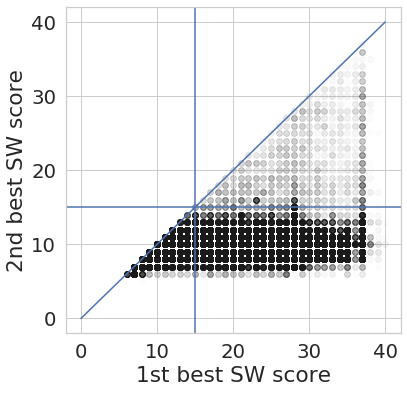

In [92]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

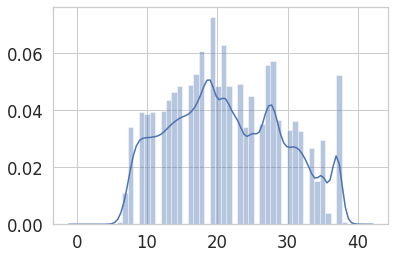

In [88]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [101]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [217]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [219]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [218]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190809/guppy_3.2.2_08_09_19_run_01_exec_20190809/sw/all_536cafc874cb995b6c8b47a5baabb9598eaded02.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [107]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits

In [124]:
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run].split(", ")
molbits_on_flowcell = []
if molbit_sets_on_flowcell != "none":
    # In the future, will need to do something here
    pass

## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [181]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [182]:
sum(accept_molbit) / len(accept_molbit)

0.7709552534437742

## Extract the best-aligned molbit, across ONLY the extant molbits

In [144]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [145]:
extant_sw = sw.loc[:, extant_sw_cols]

In [180]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/software/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [204]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [189]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [190]:
n_extant_is_best

136853

Percentage of well-aligned reads that belong to the true set

In [201]:
n_extant_is_best/len(sw_accepted)

0.9988686792012146

Read counts for each molbit

In [203]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('0', 2382),
 ('1', 2745),
 ('10', 717),
 ('11', 4777),
 ('12', 20668),
 ('13', 2029),
 ('14', 4314),
 ('15', 14026),
 ('2', 8397),
 ('3', 12899),
 ('4', 3362),
 ('5', 9185),
 ('6', 17605),
 ('7', 5901),
 ('8', 5550),
 ('9', 22451)]

## Get counts for all molbits

In [205]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

2381
2742
8376
12899
3361
9183
17603
5883
5541
22411
716
4750
20665
2021
4302
14019
0
1
0
0
2
0
0
0
3
4
0
1
1
0
3
0
0
1
0
1
1
1
0
0
1
0
1
2
2
0
1
1
0
7
1
0
0
34
0
2
15
1
7
1
0
0
1
0
2
1
0
0
0
4
0
0
0
0
0
4
4
0
0
2
0
0
0
0
7
11
0
0
1
1
0
12
0
2
2
6
